# Temporal fMRI preprocessing

(This tutorial is based on the textbook here: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_4/temporal_preprocessing.html)

Preprocessing of (f)MRI data is quite a complex topic, involving techniques from signal processing (filtering), linear algebra/statistics (prewhitening, autocorrelation correction), and numerical optimization (image registration). Additionally, there is ongoing discussion about which preprocessing steps are necessary/sufficient and what preprocessing parameters are optimal. As always, this depends on your specific research question, the type and quality of your data, and the intended analysis.

In these tutorials, we'll discuss a couple (not all!) of preprocessing steps that are common in univariate fMRI analyses across two notebooks, one discussing temporal processing (the current notebook) and one discussing spatial preprocessing (the next notebook, `09_fMRI_preprocessing2_spatial.ipynb`).

**What you'll learn**: after this tutorial, you'll ...

- be able to explain the influence of preprocessing on the measured effects using the t-value formula
- understand (the advantage of) temporal filtering from both the time-domain and frequency-domain
- understand the necessity of prewhitening given the assumptions of the GLM
- understand the advantage of spatial filtering (smoothing)
- understand how to handle outliers
- know how to implement the concepts above in Python


## Introduction
As we said before, preprocessing is a topic that almost warrants its own course. Nonetheless, we'll try to show you (and let you practice with) some of the most common and important preprocessing operations. Additionally, we'll introduce the concept of the fast fourier transform, which allows us to analyze our signal in the frequency domain, which helps to understand several preprocessing steps, such as temporal filtering.

### The *t*-value formula &mdash; yet again
The previous two weeks, you have learned that, essentially, we want to find large effects (calculated as *t*-values) of our contrasts by optimizing various parts of the *t*-value formula. Conceptually, the *t*-value formula for a particular contrast ($\mathbf{c}$) can be written as:

\begin{align}
t\mathrm{-value} = \frac{\mathrm{effect}}{\mathrm{uncertainty}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}} = \frac{\mathbf{c}\hat{\beta}}{\sqrt{\hat{\sigma}^{2}\mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}^{T}}}
\end{align}

Last week you've learned that by ensuring low design variance (through *high* predictor variance and *low* predictor correlations) leads to larger normalized effects (higher *t*-values). This week, we will discuss the other term of the denominator of this formula: the noise (also called the residual variance or unexplained variance), which is defined in the *t*-value formula as follows:

\begin{align}
\mathrm{noise} = \frac{\mathrm{SSE}}{\mathrm{DF}} = \frac{\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^{2}}{N - P}
\end{align}

Through preprocessing, we aim to reduce the difference between our prediction ($\hat{\mathbf{y}}$) and our true signal ($\mathbf{y}$), thus reducing the noise-term of the formula and thereby optimizing our ("normalized") effects.

### On temporal vs. spatial preprocessing
Roughly speaking, you can divide fMRI preprocessing into two types of operations: temporal and spatial. Temporal preprocessing involves operations that filter or otherwise affect the properties of your data across the time dimension (i.e., the time series). This is, of course, only applicable to *functional* MRI data (not structural or diffusion MRI). Examples of temporal operations are high-pass filtering and slice-time correction. Spatial preprocessing involves operations that filter or otherwise affect the spatial properties of your data (such as spatial orienatation, resolution, and shape). Examples of these spatial operations are spatial filtering ("smoothing"), distortion correction, motion correction (realignment), and spatial normalization/resampling.

In these tutorials, we'll discuss these operations per theme: we'll start with temporal operations and then move to spatial operations. Note that this *is not* the order in which data is usually preprocessed.

Let's start with temporal preprocessing.

In [11]:
# First, some imports!
import os
import numpy as np
from numpy.linalg import inv
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from scipy.interpolate import interp1d
import nibabel

import matplotlib.pyplot as plt
%matplotlib inline

import pathlib

In [12]:
path = pathlib.Path.cwd()
data_path = path.parents[3] / "798873" / "data" 

## Temporal preprocessing
In this section, we will discuss how temporal preprocessing may greatly reduce the error term of our statistics. We'll also delve into a variant of the GLM that deals with autocorrelation in our signals appropriately ("generalized least squares", or GLS).

### Slice-time correction
Slice-time correction is a temporal resampling technique that corrects for the fact that, in (most) BOLD-MRI scan sequences, volumes are acquired slice by slice. This means that each slices is acquired at a slightly different time. For example, suppose that we are acquiring an fMRI run with a TR of 1.8 seconds and our volumes consist of 36 slices (acquired axially, inferior &rarr; superior). 

![img](https://upload.wikimedia.org/wikipedia/commons/4/45/100325_RS88UH_11_qc.gif)

In this case, the acquisition of each slice takes $\frac{TR}{N_{slice}} = \frac{1.8}{36} = 0.05$ seconds (let's call this `dt`). This means that, for the very first volume, the "onset" of the first slice is at 0 seconds (and lasts until 0.05 seconds), while the onset of the last slice is at 1.75 (and lasts until 1.80 seconds). In code, we can calculate these slice onsets **within a volume** using the `np.linspace(start, stop, n_steps)` function:

In [13]:
TR = 1.8
n_slices = 36
slice_onsets_within_volume = np.linspace(0, TR, n_slices, endpoint=False)
# Note, this would have worked as well: np.arange(0, TR, TR / 40)

print("Length of slice onsets: %i" % slice_onsets_within_volume.size, end='\n\n')
print("Onsets of slices for first volume: %s" % (slice_onsets_within_volume,), end='\n\n')
print("Acquisition of first slice (of first volume) started at %.2f sec." % slice_onsets_within_volume[0])
print("Acquisition of last slice (of first volume) started at %.2f sec." % slice_onsets_within_volume[-1])

Length of slice onsets: 36

Onsets of slices for first volume: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Acquisition of first slice (of first volume) started at 0.00 sec.
Acquisition of last slice (of first volume) started at 1.75 sec.


Now, let's assume we do a very simple experiment, lasting 32 seconds (i.e., 16 volumes with a TR of 2), in which we show a single stimulus at $t=0$. Furthermore, let's assume that the *entire brain* responds to this stimulus with an idealized (noiseless response). In other words, the response of each voxel will look exactly like the HRF:

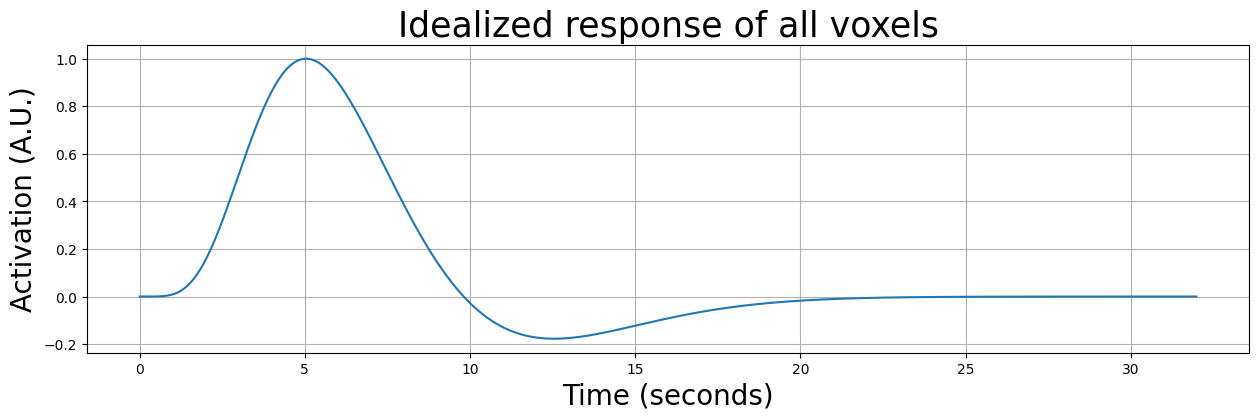

In [14]:
TR=2
n_slices=40
oversampling = 100
exp_length = 32
n_vols = 32 // TR

ideal_response = glover_hrf(tr=TR, time_length=exp_length, oversampling=TR * oversampling)
ideal_response /= ideal_response.max()
t = np.linspace(0, exp_length, ideal_response.size, endpoint=False)

plt.figure(figsize=(15, 4))
plt.plot(t, ideal_response)
plt.grid()
plt.title("Idealized response of all voxels", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.show()

We must, however, take into accout that, even when our data would represent an idealized response, it would be sampled at different timepoints due to a difference in onsets for different slices. The first slice would for example be sampled at $[0, 2, 4, 6, ..., 30]$ seconds, while, for example, the middle slice would be sampled at $[1, 3, 5, ... 31]$ seconds. We can calculate the onset per slice **across volumes** using `np.linspace` again:

```python
# Note: this is the onset of slice number "slice_num" **across volumes**
onsets_slice_across_volumes = np.linspace(dt * slice_num, length_exp + dt * slice_num, n_vols, endpoint=False)
```

where `dt` is the time it takes per slice (i.e., $dt = \frac{TR}{N_{slice}}$). So, to get the slice times for, e.g. slice number 23, for the experiment we have so far (i.e., with a TR of 2, 40 slices, and 32 second duration), we would compute the onsets as follows:

In [15]:
dt = TR / n_slices
slice_num = 23

# note the slice_num - 1, as Python uses 0-based indexing
start = dt * (slice_num - 1)
end = exp_length + dt * (slice_num - 1)
onsets_slice23_across_volumes = np.linspace(start, end, n_vols, endpoint=False)
print(onsets_slice23_across_volumes)

[ 1.1  3.1  5.1  7.1  9.1 11.1 13.1 15.1 17.1 19.1 21.1 23.1 25.1 27.1
 29.1 31.1]


So, even with a noiseless response, the data will look different per slice. We'll plot this below for the first slice and the middle slice (on top of the idealized response):

Onset acquisition of slice 0 (first 10 volumes): [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Onset acquisition of slice 20 (first 10 volumes): [ 0.95  2.95  4.95  6.95  8.95 10.95 12.95 14.95 16.95 18.95]


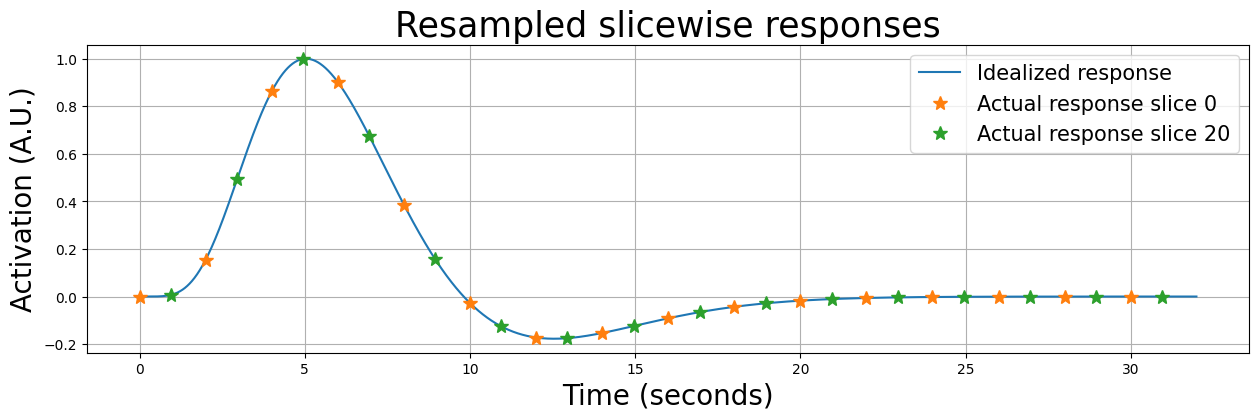

In [16]:
onsets_s0_across_volumes = np.linspace(0, exp_length, n_vols, endpoint=False)
onsets_s20_across_volumes = np.linspace(dt * 19, exp_length + dt * 19, n_vols, endpoint=False)

print("Onset acquisition of slice 0 (first 10 volumes): %s" % (onsets_s0_across_volumes[:10],))
print("Onset acquisition of slice 20 (first 10 volumes): %s" % (onsets_s20_across_volumes[:10],))

# "Fit" the interpolation 
resampler = interp1d(t, ideal_response)

plt.figure(figsize=(15, 4))
plt.plot(t, ideal_response)
plt.grid()
plt.title("Resampled slicewise responses", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)

for onsets in [onsets_s0_across_volumes, onsets_s20_across_volumes]:
    # Do not use this code as an example to solve the next ToDo!
    # Because it does it the other way around.
    slice_sig = resampler(onsets)  # resample to slice times! kind of like inverse slice-time correction
    plt.plot(onsets, slice_sig, marker='*', ls='None', ms=10)

plt.legend(['Idealized response', 'Actual response slice 0', 'Actual response slice 20'],
           fontsize=15)
plt.show()

Now, if we would ignore the fact that these signals were acquired at different times (by assuming they were all acquired at $t=0, t=2, t=4$ etc.), our model will be suboptimal for all slices (except for slice 0). We'll show this below by plotting the resampled data from  slice 0, 20, and 39 on top of the idealized response (which represents our predictor):

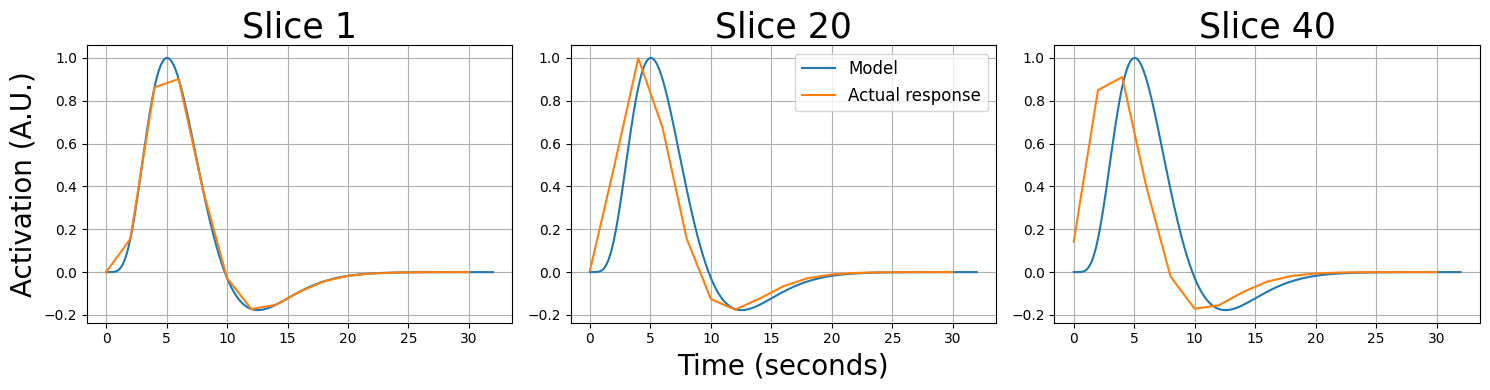

In [17]:
plt.figure(figsize=(15, 4))

slice_data = np.zeros((slice_sig.size, 3))
slice_onsets_across_volumes = np.zeros((slice_sig.size, 3))
for i, slc in enumerate([0, 19, 39]):
    t_slice = np.linspace(dt * slc, exp_length + dt * slc, n_vols, endpoint=False)
    slice_resp = resampler(t_slice)
    slice_data[:, i] = slice_resp  # save for later
    slice_onsets_across_volumes[:, i] = t_slice
    plt.subplot(1, 3, i+1)
    plt.plot(t, ideal_response)
    plt.plot(onsets_s0_across_volumes, slice_resp)
    plt.title("Slice %i" % (slc + 1), fontsize=25)
    plt.grid()
    
    if i == 0:
        plt.ylabel("Activation (A.U.)", fontsize=20)
    
    if i == 1:
        plt.xlabel("Time (seconds)", fontsize=20)
        plt.legend(['Model', 'Actual response'], fontsize=12)

plt.tight_layout()
plt.show()

As you can see, "later" slices are quite misaligned relative to the idealized response/model (which assume that each slice is acquired at the start of the volume). We can fix this by *resampling the data from different slices to the onset times of a reference slice*. Basically, this amounts to saying: "what would the signal from slice x look like if it was acquired at the onsets of a reference slice". This process is called *slice-time correction*. 

Remember the temporal resampling of our "high precision" predictors that we did in week 2? We're going to do something similar to our data, here. Basically, we are going to resample our slice-wise timesieres corresponding to a particular set of onsets (let's call these the `original_onsets`) to the set of onsets of a particular reference slice (let's call these the `desired_onsets`). Using the same `interp1d` function from week 2, we can do the following:

```python
resampler = interp1d(original_onsets, original_signal)
std_signal = resampler(desired_onsets)
```

where `original_onsets` is a numpy array with onsets of each slice **across volumes** and the `original_signal` refers to the actual signal of that voxel (here: slice). They should be the same size. The `desired_onsets` is another numpy array with, *in the case of slice-time correction*, the same size as `original_onsets`.

Below, we'll pick the first slice as the reference slice.

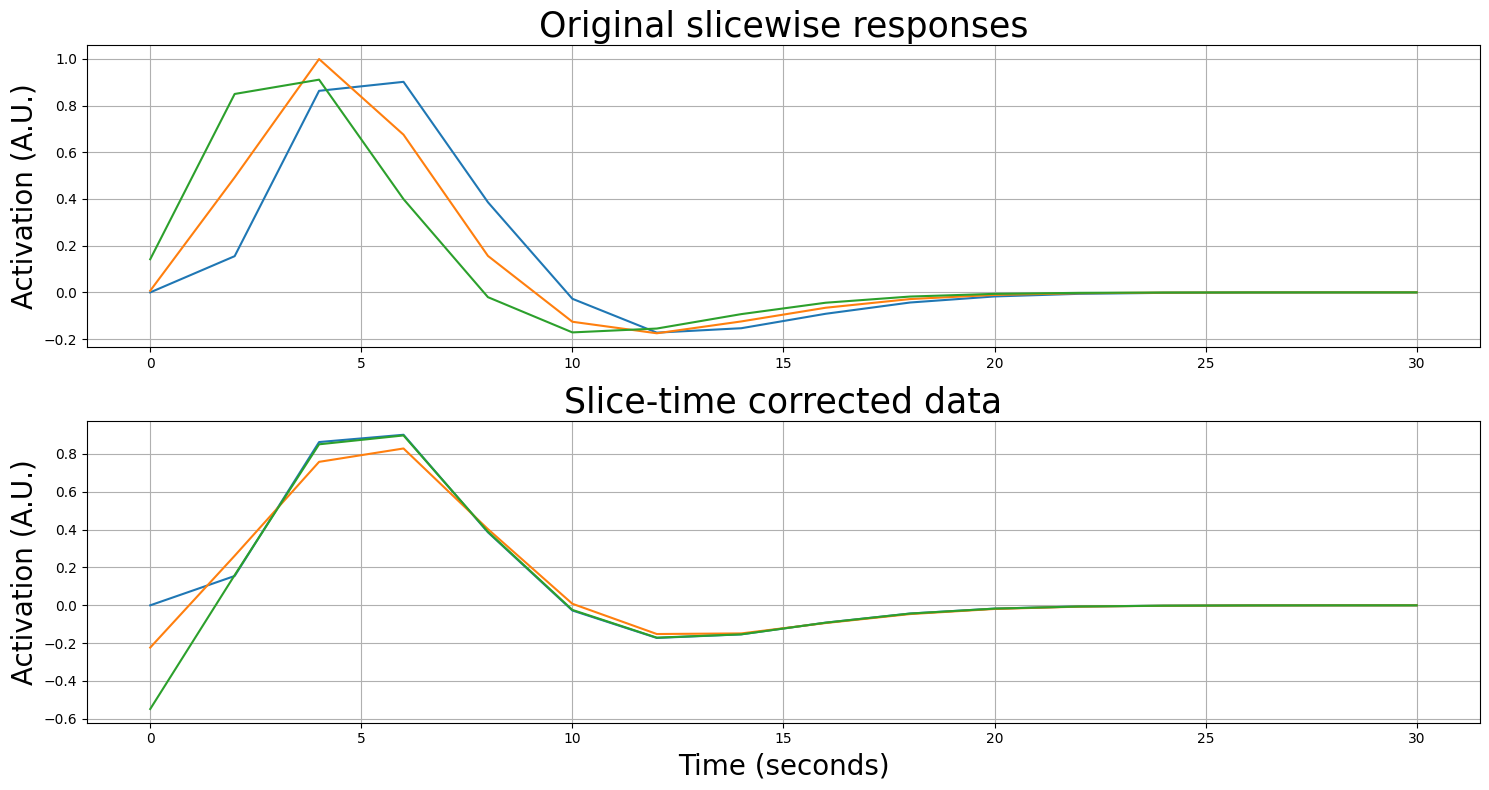

In [18]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
for i in range(slice_data.shape[1]):
    plt.plot(onsets_s0_across_volumes, slice_data[:, i])
    plt.grid()
    plt.ylabel("Activation (A.U.)", fontsize=20)
    plt.title("Original slicewise responses", fontsize=25)

# Define reference slice as the first one (with onsets [0, 2, 4, 6, etc])
desired_onsets = onsets_s0_across_volumes

plt.subplot(2, 1, 2)
for i in range(slice_data.shape[1]):
    
    # Resample slice-specific onsets to desired onsets
    resampler = interp1d(slice_onsets_across_volumes[:, i], slice_data[:, i], fill_value='extrapolate')
    stc_slice = resampler(desired_onsets)
    
    # Plot relative to the reference onsets, i.e., onsets_s0 (first slice)
    plt.plot(onsets_s0_across_volumes, stc_slice)
    plt.grid()
    plt.title("Slice-time corrected data", fontsize=25)
    plt.xlabel("Time (seconds)", fontsize=20)
    plt.ylabel("Activation (A.U.)", fontsize=20)
    
plt.tight_layout()
plt.show()

As you can see, the resampled time series resemble each other much more after slice-time correction! It's showing some "edge artifacts" which are caused by extrapolation of the time series. In actual neuroimaging software packages, higher-order resampling (such as "cubic" or "spline" resampling) are used to somewhat mitigate this. Moreover, instead of the first slice, usually the middle slice is chosen as the reference slice, which reduces the amount of resampling (and extrapolation) that has to be done, further mitigating artifacts. 

#### Example using cubic interpolation

Below, we load in new data (<tt>slice_data</tt>) from a very short experiment (60 seconds, TR = 3). The data are from 1 voxel from every of the 32 slices. 

We will:
- Implement slice-time correction by resampling each slice to the onsets of the middle slice (slice no. 16). 
- Use "cubic" interpolation (by setting <tt>kind="cubic"</tt> when initializing your resampler). 
- Store the results in the pre-allocated array <tt>stc_data</tt>.
- Plot the data to see the effect.


Slice data is of shape (time x slices): (20, 32)


Text(0, 0.5, 'Activation (A.U.)')

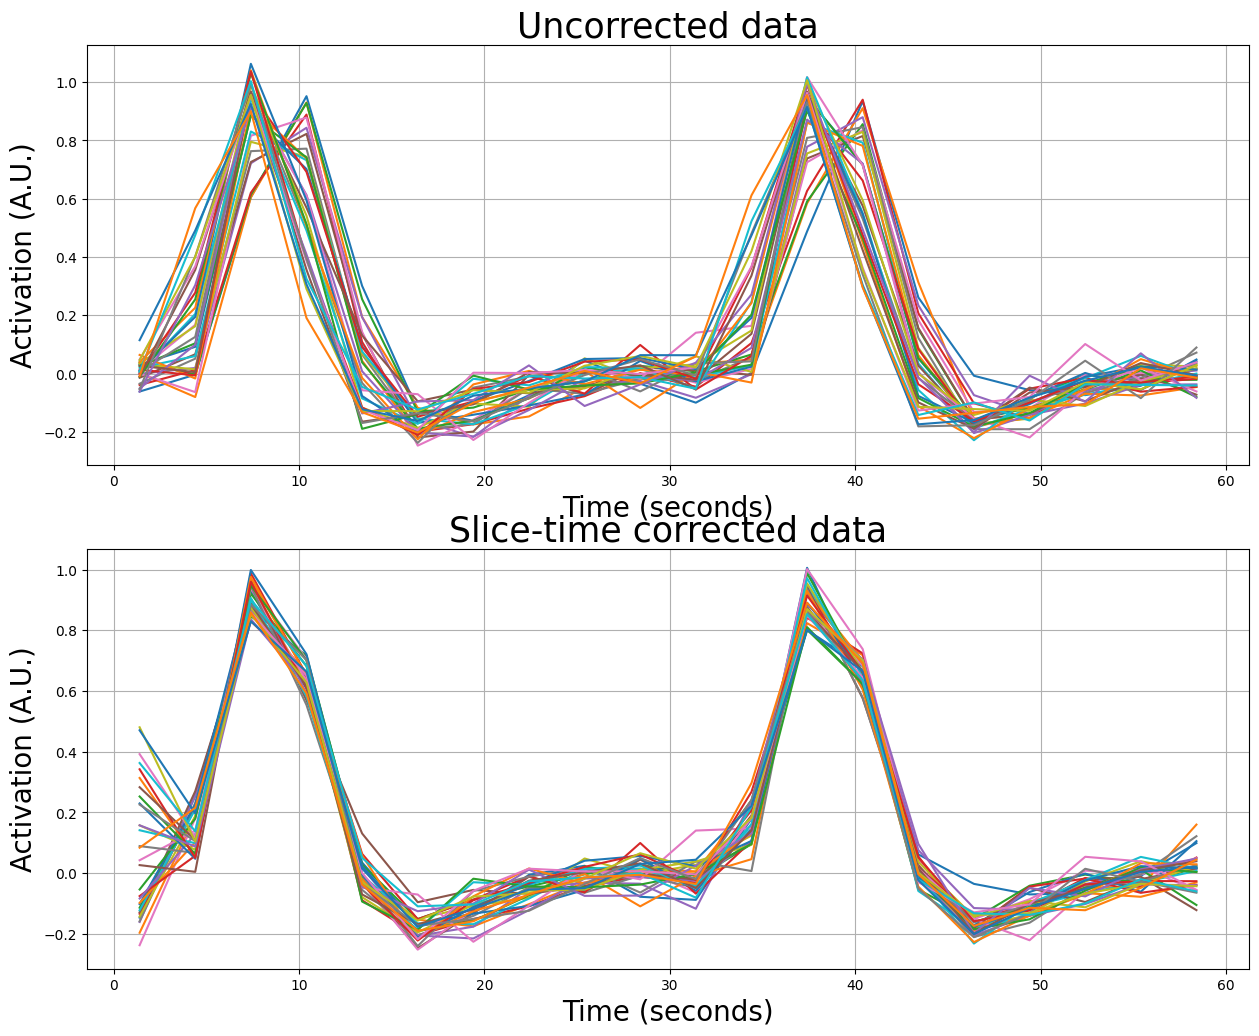

In [19]:
slice_data = np.load(data_path / 'stc_data.npy')
print("Slice data is of shape (time x slices): %s" % (slice_data.shape,))

stc_data = np.zeros(slice_data.shape)

#Adding information about our exp.
TR = 3
n_vols, n_slices = slice_data.shape
exp_length = TR * n_vols
dt = TR / n_slices

#Create vector with reference onsets. Use middle slice as reference (slice 15, given that Python uses 0-index) 
ref_onsets = np.linspace(dt * 15, exp_length + dt * 15, n_vols, endpoint=False)


#Initialize vector with corrected data
stc_data = np.zeros_like(slice_data)
#loop to interpolate to correct
for i in range(stc_data.shape[1]):
    t = np.linspace(dt * i, exp_length + dt * i, n_vols, endpoint=False)
    resampler = interp1d(t, slice_data[:, i], fill_value='extrapolate', kind='cubic')
    stc_data[:, i] = resampler(ref_onsets)


# Make a plot to investigate
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)

# Plot uncorrected
plt.plot(ref_onsets, slice_data)
plt.grid()
plt.title("Uncorrected data", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)  
plt.subplot(2, 1, 2)    
# Plot corrected
plt.plot(ref_onsets, stc_data)
plt.grid()
plt.title("Slice-time corrected data", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)    

### A short primer on the frequency domain and the Fourier transform
Now, before we'll delve into important temporal preprocessing operations, let's discuss how we can represent time series in the frequency domain using the Fourier transform.

Thus far, we've always looked at our fMRI-signal as activity that varies across **time**. In other words, we're always looking at the signal in the *time domain*. However, there is also a way to look at a signal in the *frequency domain* (also called 'spectral domain') through transforming the signal using the *Fourier transform*. 

Basically, the fourier transform calculates to which degree sine waves of different frequencies are present in your signal. If a sine wave of a certain frequency (let's say 2 hertz) is (relatively) strongly present in your signal, it will have a (relatively) high *power* in the frequency domain. Thus, looking at the frequency domain of a signal can tell you something about the frequencies of the (different) sources underlying your signal.

This may sound quite abstract, so let's look at some examples.

In [20]:
# start with importing the python package we'll need and making a little function 
from scipy.ndimage import affine_transform

def create_sine_wave(timepoints, frequency=1,amplitude=1, phase=0):
    return amplitude * np.sin(2 * np.pi * frequency * timepoints + phase)

Sine waves are oscillating signals that have (for our purposes) two important characteristics: their *frequency* and their *amplitude*. Frequency reflects how fast a signal is oscillating (how many cycles it completes in a given time period) and the amplitude is the (absolute) height of the peaks and troughs of the signal. To illustrate this, we generate a couple of sine-waves (with a sampling rate of 500 Hz, i.e., 500 samples per second) with different amplitudes and frequencies, which we plot below:

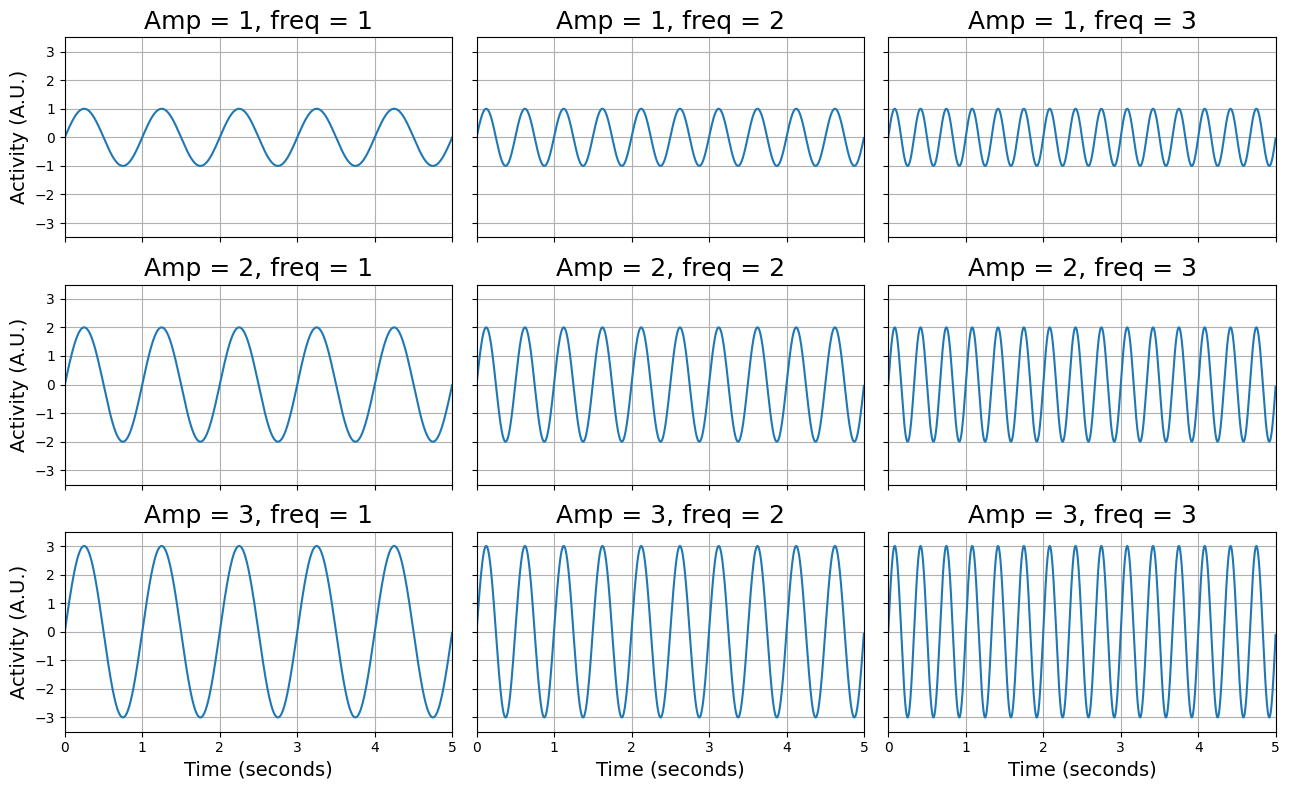

In [21]:
max_time = 5
sampling_rate = 500
timepoints = np.arange(0, max_time, 1.0 / sampling_rate)

amplitudes = np.arange(1, 4)
frequencies = np.arange(1, 4)
sines = []

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 8))
for i, amp in enumerate(amplitudes):
    
    for ii, freq in enumerate(frequencies):
        this_ax = axes[i, ii]
        
        if ii == 0:
            this_ax.set_ylabel('Activity (A.U.)', fontsize=14)
        
        if i == 2:
            this_ax.set_xlabel('Time (seconds)', fontsize=14)
        
        sine = create_sine_wave(timepoints, frequency=freq, amplitude=amp)    
        sines.append((sine, amp, freq))
        this_ax.plot(timepoints, sine)
        this_ax.set_xlim(0, 5)
        this_ax.set_title('Amp = %i, freq = %i' % (amp, freq), fontsize=18)
        this_ax.set_ylim(-3.5, 3.5)
        this_ax.grid()

fig.tight_layout()

As you can see, the signals vary in their amplitude (from 1 to 3) and their frequency (from 1 - 3). Make sure you understand these characteristics! Now, we are going to use the fast fourier transform to plot the same signals in the *frequency domain*. We're not going to use a function to compute the FFT-transformation, but we're going to use a function that computes the "power spectrum density" directly (which makes life a little bit easier): the `periodogram` function from `scipy.signal`:

In [22]:
from scipy.signal import periodogram

Now, the `periodogram` function takes two arguments, the signal and the sampling frequency (the sampling rate in Hz with which you recorded the signal), and returns both the reconstructed frequencies and their associated power values. An example:

```python
freqs, power = periodogram(some_signal, 1000)  # sampling_rate = 1000 Hz
```

We'll use the `periodogram` function to plot the 9 sine-waves (from the previous plot) again, but this time in the frequency domain:

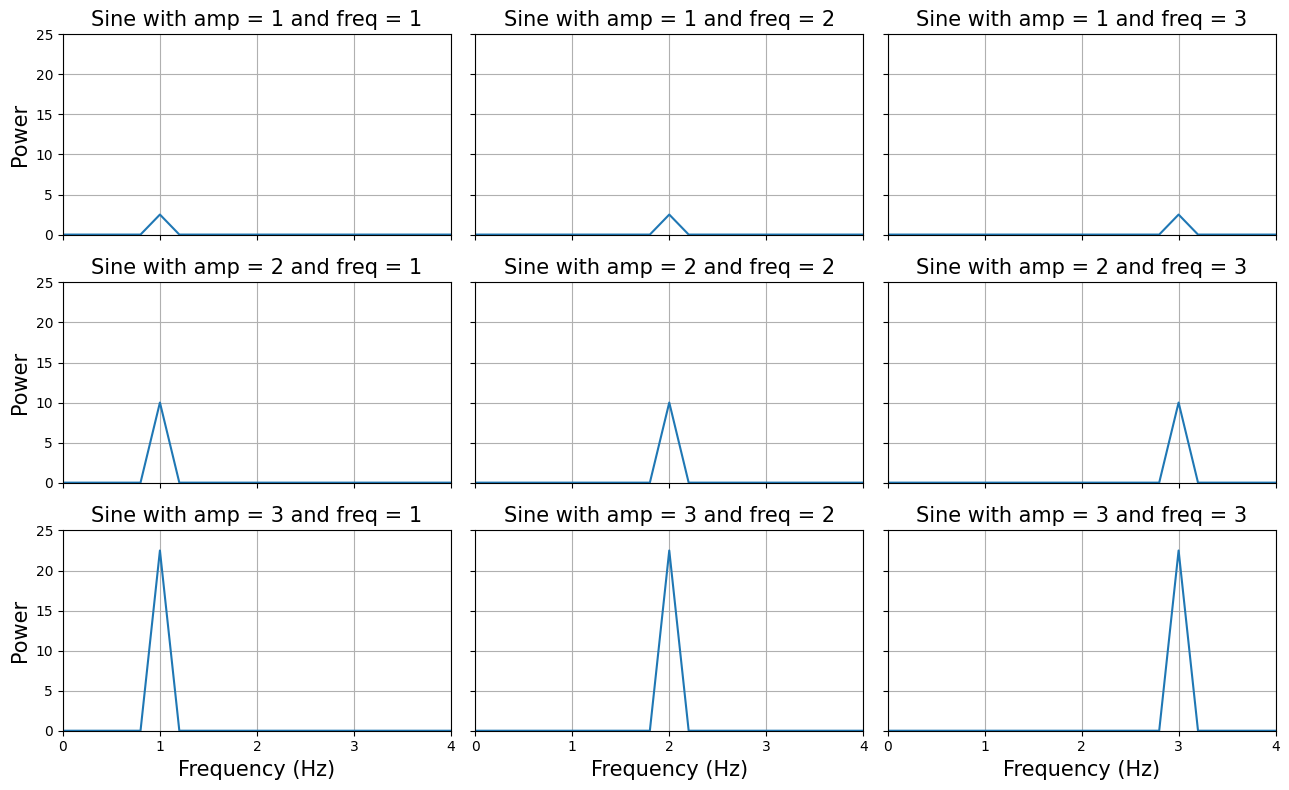

In [23]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 8))

for i, ax in enumerate(axes.flatten()):
    sine, amp, freq = sines[i]
    title = 'Sine with amp = %i and freq = %i' % (amp, freq)
    freq, power = periodogram(sine, sampling_rate)
    ax.plot(freq, power)
    ax.set_xlim(0, 4)
    ax.set_xticks(np.arange(5))
    ax.set_ylim(0, 25)
    
    if i > 5:
        ax.set_xlabel('Frequency (Hz)', fontsize=15)
    
    if i % 3 == 0:
        ax.set_ylabel('Power', fontsize=15)

    ax.set_title(title, fontsize=15)
    ax.grid()
    
fig.tight_layout()
plt.show()

As you can see, the frequency domain correctly 'identifies' the amplitudes and frequencies from the signals. But the real 'power' from fourier transforms is that they can reconstruct a signal in *multiple underlying oscillatory sources*. Let's see how that works. We're going to load in a time-series recorded for 5 seconds of which we don't know the underlying oscillatory sources. First, we'll plot the signal in the time-domain:

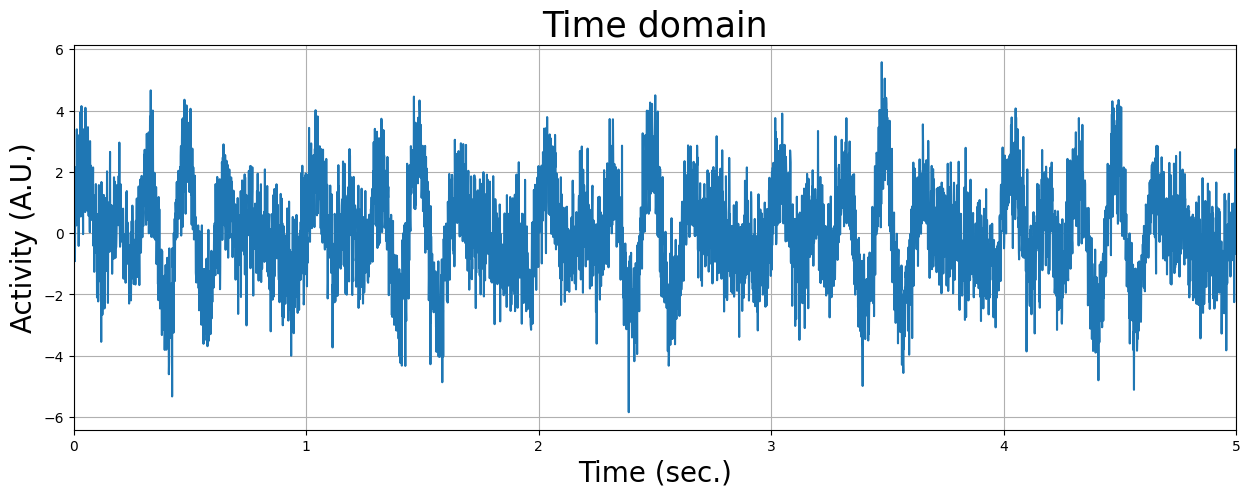

In [26]:
mystery_signal = np.load(data_path / 'mystery_signal.npy')
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, 5, 0.001), mystery_signal)
plt.title('Time domain', fontsize=25)
plt.xlim(0, 5)
plt.xlabel('Time (sec.)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.grid()
plt.show()

It's hard to see which frequencies (and corresponding amplitudes) are present in this 'mystery signal'. We will get the frequencies and power of the signal using the <tt>periodogram</tt> function. First we have to deduce the sampling rate of the signal (in sec). It is the number of samples in the signal divided by its duration in seconds. We will set the x-limit of the x-axis to (0, 8) (<tt>plt.xlim(0, 8)</tt>) and also, give the plot appropriate labels for the axes.

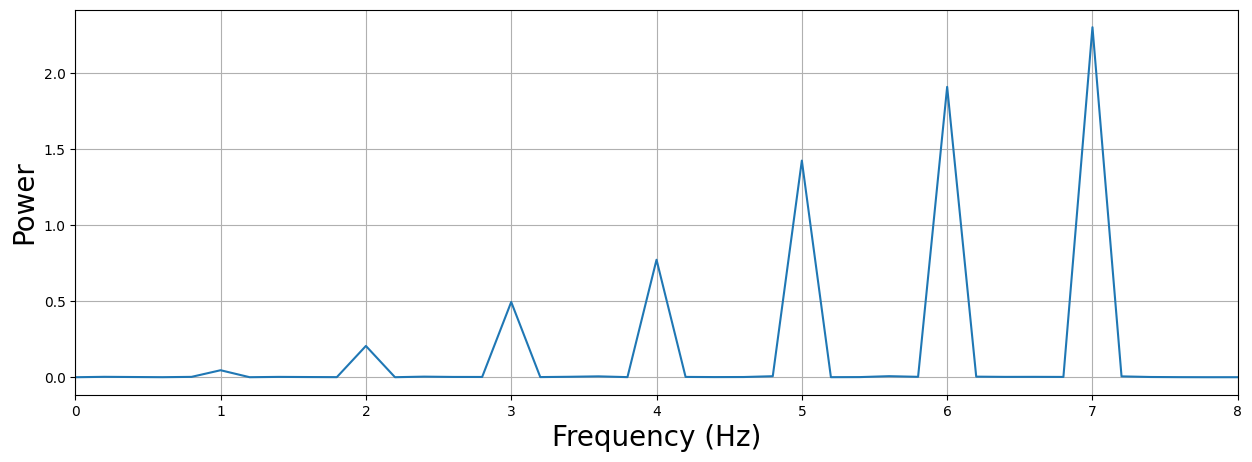

In [27]:

freqs, pows = periodogram(mystery_signal, fs=mystery_signal.size / 5)
plt.figure(figsize=(15, 5))
plt.plot(freqs, pows)
plt.xlim(0, 8)
plt.ylabel('Power', fontsize=20)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.grid()
plt.show()



Now you know that you can use visualization of the signal in the frequency domain to help you understand from which underlying frequencies your signal is built up. Unfortunately, real fMRI data is not so 'clean' as the simulated sine waves we have used here, but the frequency representation of the fMRI signal can still tell us a lot about the nature and contributions of different (noise- and signal-related) sources!

### Frequency characteristics of fMRI data
Now, we will simulate a (much noisier) voxel signal and the corresponding design-matrix (which has just one predictor apart from the intercept). The signal was measured with a TR of 2 seconds and contains 300 volumes (timepoints), so the duration was 600 seconds. The predictor reflects an experiment in which we showed 15 stimuli in intervals of 40 seconds (i.e., one stimulus every 40 seconds).

First, we will define the data simulation function that we have used before:

In [28]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf, glover_time_derivative
from scipy.linalg import toeplitz

def simulate_signal(onsets, conditions, TR=2, duration=None, icept=0, params_canon=None, params_tderiv=None,
                    params_deriv1=None, phi=None, std_noise=1, osf=100, rnd_seed=None, plot=True):
    """ Simulates a somewhat realistic voxel signal with an associated design matrix. """
    if rnd_seed is not None:
        np.random.seed(rnd_seed)
    
    conds = sorted(np.unique(conditions))
    P = len(conds)
    
    if duration is None:
        duration = np.max(onsets) + 30
    
    if params_canon is None:
        params_canon = np.zeros(P)

    # TMP FIX
    params_tderiv = params_deriv1
    
    if params_tderiv is None:
        params_tderiv = np.zeros(P)

    X = np.zeros((duration * osf, P))
    for ons, con in zip(onsets, conditions):
        X[int(ons * osf), conds.index(con)] = 1
        
    hrf = glover_hrf(tr=1, oversampling=osf)
    hrf_d = glover_time_derivative(tr=1, oversampling=osf)

    t_orig = np.arange(0, duration, 1 / osf)
    t_new = np.arange(0, duration, TR)
    
    Xconv = np.zeros((t_orig.size, P * 2))
    idx = 0
    for i, this_hrf in enumerate([hrf, hrf_d]):
        this_hrf /= this_hrf.max()
        for ii in range(P):
            Xconv[:, idx] = np.convolve(X[:, ii], this_hrf)[:t_orig.size]  
            idx += 1
    
    Xconv = np.c_[np.ones(Xconv.shape[0]), Xconv]
    params = np.r_[icept, params_canon, params_tderiv]
    y = Xconv @ params
    
    resampler = interp1d(t_orig, y)
    y = resampler(t_new)       
    
    if phi is None:
        noise_cov = std_noise ** 2 * np.eye(y.size)
    else:
        noise_cov = std_noise ** 2 * phi ** toeplitz(np.arange(y.size))
    
    y = y + np.random.multivariate_normal(np.zeros(y.size), noise_cov)

    Xconv_ds = np.zeros((t_new.size, Xconv.shape[1]))
    for i in range(Xconv.shape[1]):
        resampler = interp1d(t_orig, Xconv[:, i])
        Xconv_ds[:, i] = resampler(t_new)
    
    est_betas = np.linalg.lstsq(Xconv_ds, y, rcond=None)[0]
    if plot:
        plt.figure(figsize=(15, 5))
        plt.plot(y)
        plt.plot(Xconv_ds @ est_betas)
        plt.xlim(0, y.size)
        plt.legend(['y', 'y-hat'])
        plt.show()

    return y, Xconv_ds

Next, we'll generate and plot both the signal ($y$) with simulated onsets every 40 seconds. We will also create the design-matrix ($X$; without intercept), while we are at it:

Shape of X: (300, 2)
Shape of y (sig): (300,)


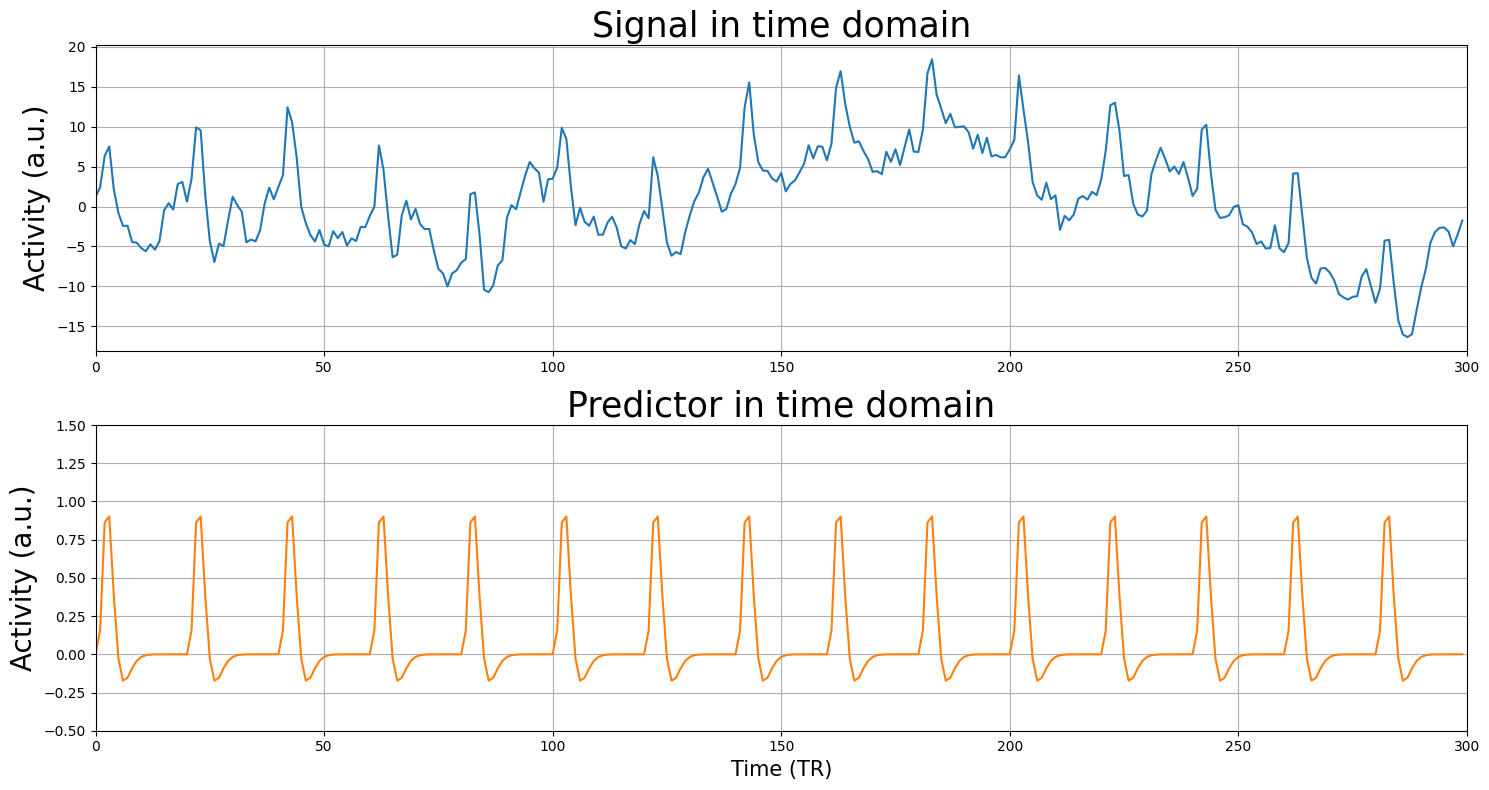

In [29]:
# Let's make it an experiment with 40 onsets and 600 second duration
onsets = np.arange(0, 600, 40)

#Simulate som data and call it sig. Also prepare a design matrix (X)
sig, X = simulate_signal(
    onsets,
    ['stim'] * onsets.size,
    duration=600,
    TR=2,
    icept=0,
    params_canon=[10],
    std_noise=5,
    rnd_seed=29,
    phi=0.95,
    plot=False
)
X = X[:, :-1]  # trim off the temporal derivative

print("Shape of X: %s" % (X.shape,))
print("Shape of y (sig): %s" % (sig.shape,))

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(sig)
plt.xlim(0, sig.size)
plt.title('Signal in time domain', fontsize=25)
plt.ylabel('Activity (a.u.)', fontsize=20)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(sig.size), X[:, 1], c='tab:orange')
plt.title('Predictor in time domain', fontsize=25)
plt.xlabel('Time (TR)', fontsize=15)
plt.xlim(0, sig.size)
plt.ylabel('Activity (a.u.)', fontsize=20)
plt.ylim(-0.5, 1.5)
plt.tight_layout()
plt.grid()
plt.show()


<b>Next, we will</b> 
- run linear regression using the variable <tt>X</tt> (which already contains an intercept) to explain the variable <tt>sig</tt>. 
- calculate the model's MSE, and store this in a variable named <tt>mse_no_filtering</tt>. 
- plot the signal and the predicted signal ($\hat{y}$) in a single figure. Give the axes sensible labels and add a legend.


MSE without filtering: 32.31426158992288


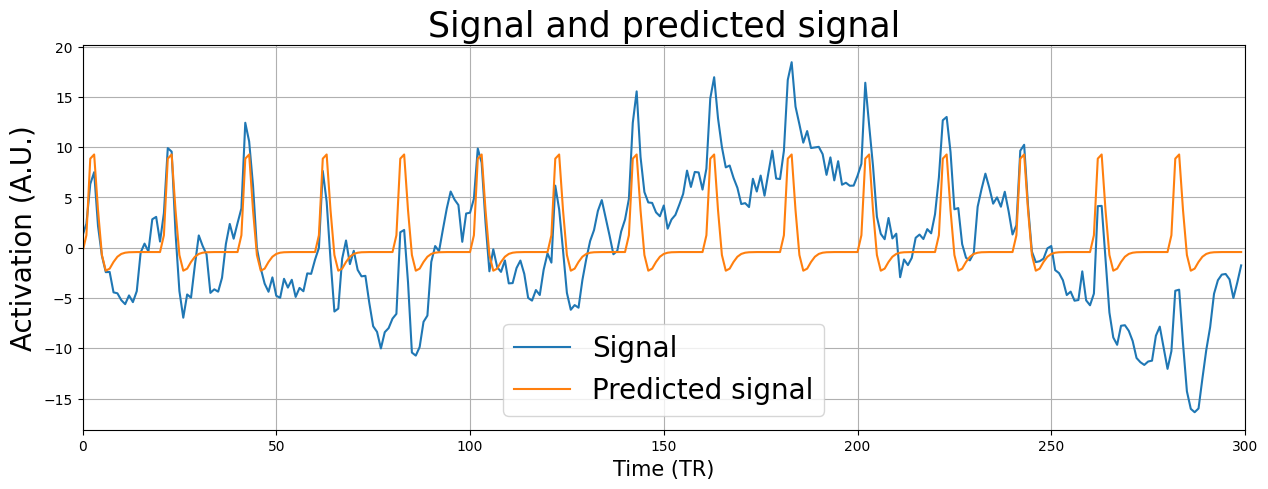

In [30]:
# Estimate model
b = inv(X.T @ X) @ X.T @ sig
# Calculate predicted values
yhat = X @ b
# Calculate mean squared error
mse_no_filtering = np.mean((sig - yhat) ** 2)
print("MSE without filtering:", mse_no_filtering)

#Plot signal and predicted signal
plt.figure(figsize=(15, 5))
plt.plot(sig)
plt.plot(yhat)
plt.xlim(0, sig.size)
plt.title("Signal and predicted signal", fontsize=25)
plt.xlabel("Time (TR)", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.legend(['Signal', 'Predicted signal'], fontsize=20)
plt.grid()
plt.show()


<div class='alert alert-info'>
<b>ToThink1</b>: In your plot above, you should see that the fit of your model is "off" due to some low frequency drift. Name two potential causes of drift.
</div>

Write your answer to the ToThink1 question here:
1. Slowly decreasing homogeneity of the magnetic field (e.g. due to subject movement)
2. Increasing thermal noise (i.e., the scanner warms up)

Note: just "subject movement" or respiration/cardiac signal is NOT correct.

### Two approaches to temporal preprocessing

Basically, there are *two* ways to preprocess your data:
1. Manipulating the signal ($\mathbf{y}$) **directly** *before* fitting your GLM-model;
2. Including "noise predictors" in your design ($\mathbf{X}$) when fitting your model;

Often, preprocessing steps can be done both by method 1 (manipulating the signal directly) and by method 2 (including noise predictors). For example, you could apply a high-pass filter by applying a "gaussian weighted running line smoother" (the method FSL employs) *directly* on the signal (method 1) **or** you could add "low-frequency (drift) predictors" to the design matrix (method 2; the SPM method is to use a 'discrete cosine basis set'). In practice, both methods often yield very similar resuls. The most important thing to understand is that both methods are trying to accomplish the same goal: reduce the noise term of the model.

First, we will discuss how temporal and spatial filtering can *directly* filter the signal (method 1) to reduce error. Later in the tutorial, we will discuss including adding outlier-predictors and motion-predictors to the design to reduce noise (method 2). 

### High-pass filtering of fMRI data (option 1)
From the previous analysis, you probably noticed that the fit of the predictor to the model was not very good. The cause for this is the slow 'drift' &mdash; a low-frequency signal &mdash; that prevents the model from a good fit. Using a high-pass filter &mdash; meaning that you *remove* the low-frequency signals and thus *pass only the high frequencies* &mdash; can, for this reason, improve the model fit. But before we go on with actually high-pass filtering the signal, let's take a look at the frequency domain representation of our voxel signal: 

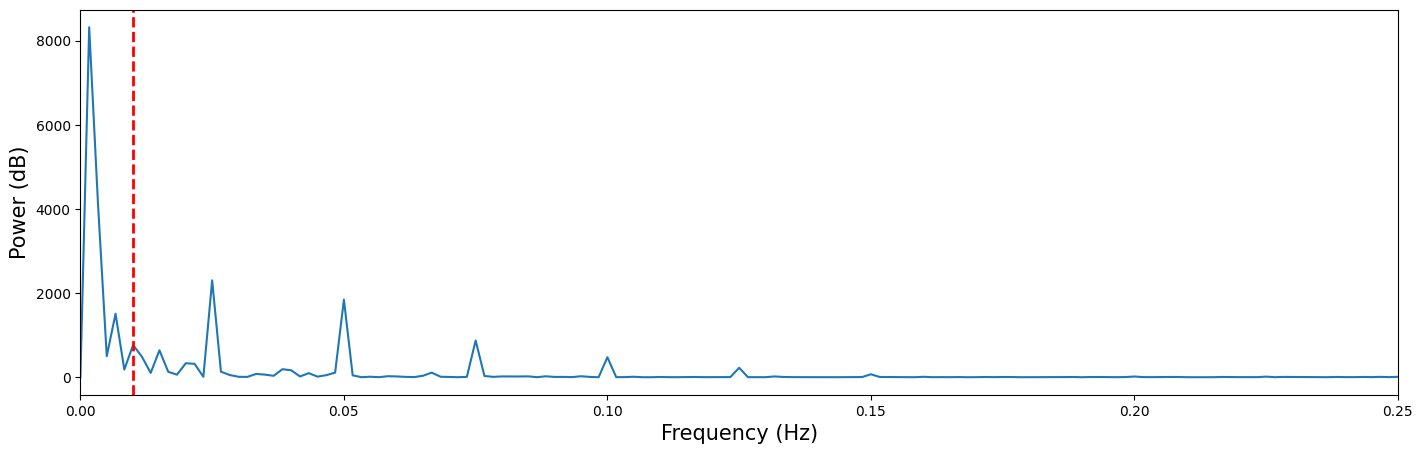

In [32]:
plt.figure(figsize=(17, 5))
TR = 2
sampling_frequency = 1 / TR  # our sampling rate is 0.5, because our TR is 2 sec!
freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power)
plt.xlim(0, freq.max())
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel('Power (dB)', fontsize=15)
plt.axvline(x=0.01,color='r',ls='dashed', lw=2)

plt.show()

In the frequency-domain plot above, you can clearly see a low-frequency drift component at frequencies approximately below 0.01 Hz (i.e., left of the dashed red line).

<div class='alert alert-info'>
<b>ToThink2</b>: Apart from the low frequency drift component around 0.01 Hz, there is also a component visible at 0.025 Hz (and its <a href="https://en.wikipedia.org/wiki/Harmonic">harmonics</a> at 0.05, 0.075, 0.1, etc.). What does this component represent? Please explain (concisely).
</div>

Write your answer to the ToThink2 question here: The observed signal frequencies reflect our expected/simulated response to the stimuli! We simulated a stimulus every 40 seconds (20 TRs), which represents a frequency of 0.025 (i.e., 1 / 40)!

Now, let's get rid of that pesky low frequency drift that messes up our model! There is no guideline on how to choose the cutoff of your high-pass filter, but most recommend to use a cutoff of around 100 seconds (i.e., of 0.01 Hz). This means that any oscillation slower than 100 seconds (one cycle in 100 seconds) is removed from your signal.

There are many different ways to high-pass your signal (e.g., frequency-based filtering methods vs. time-based filtering methods). Here, we demonstrate a time-based 'gaussian running line smoother', which is used in FSL (one of the packages developed for analysis of neuroimaging data). This high-pass filter is estimated by convolving a gaussian "kernel" with the signal (taking the element-wise product and summing the values) across time.

One implementation of this filter is included in the scipy "ndimage" subpackage. Let's import it\*:

---
\***Note**: if you're going to restart your kernel during the lab for whatever reason, make sure to re-import this package to avoid `NameErrors` (i.e., the error that you get when you call a function that isn't imported).

In [33]:
from scipy.ndimage import gaussian_filter

The `gaussian_filter` function takes two mandatory input: some kind of (n-dimensional) signal and a cutoff, "sigma", that refers to the width of the gaussian filter in standard deviations. "What? We decided to define our cutoff in seconds (or, equivalently, Hz), right?", you might think. For some reason neuroimaging packages seem to define cutoff for their temporal filters in **seconds** while more 'low-level' filter implementations (such as in scipy) define cutoffs (of gaussian filters) in **the width of the gaussial filter**, i.e., **sigma**. Fortunately, there is an easy way to convert a cutoff in seconds to a cutoff in sigma, given a particular TR (in seconds):

\begin{align}
\sigma = \frac{\mathrm{cutoff}_{sec}}{\sqrt{8\ln{2}} \cdot \mathrm{TR}_{sec}}
\end{align}

where $\ln{2}$ refers to the natural logarithm (i.e., log with base $e$).


<b>Calculating sigma</b>: Our simulated fMRI data (600 volumes) has a sampling frequency of 0.5 Hz (TR= 2s) and I would like to apply a high-pass filter of 100 seconds. What sigma should I choose? 

Let's calculate sigma and store it in a variable named <tt>sigma_100</tt>. We will use the function <tt>np.log(some_number)</tt> to evaluate the natural logarithm of a number.


In [34]:
sigma_100 = 100 / (np.sqrt(8 * np.log(2)) * 2)
print(sigma_100)

21.233045007200477


Importantly, the gaussian filter *does not return the filtered signal itself*, but the estimated low-frequency component of the data. As such, to filter the signal, we have to subtract this low-frequency component from the original signal to get the filtered signal! 

Below, we estimate the low-frequency component using the high-pass filter first and plot it together with the original signal, which shows that it accurately captures the low-frequency drift (upper plot). Then, we subtract the low-frequency component from the original signal to create the filtered signal, and plot it together with the original signal to highlight the effect of filtering (lower plot):

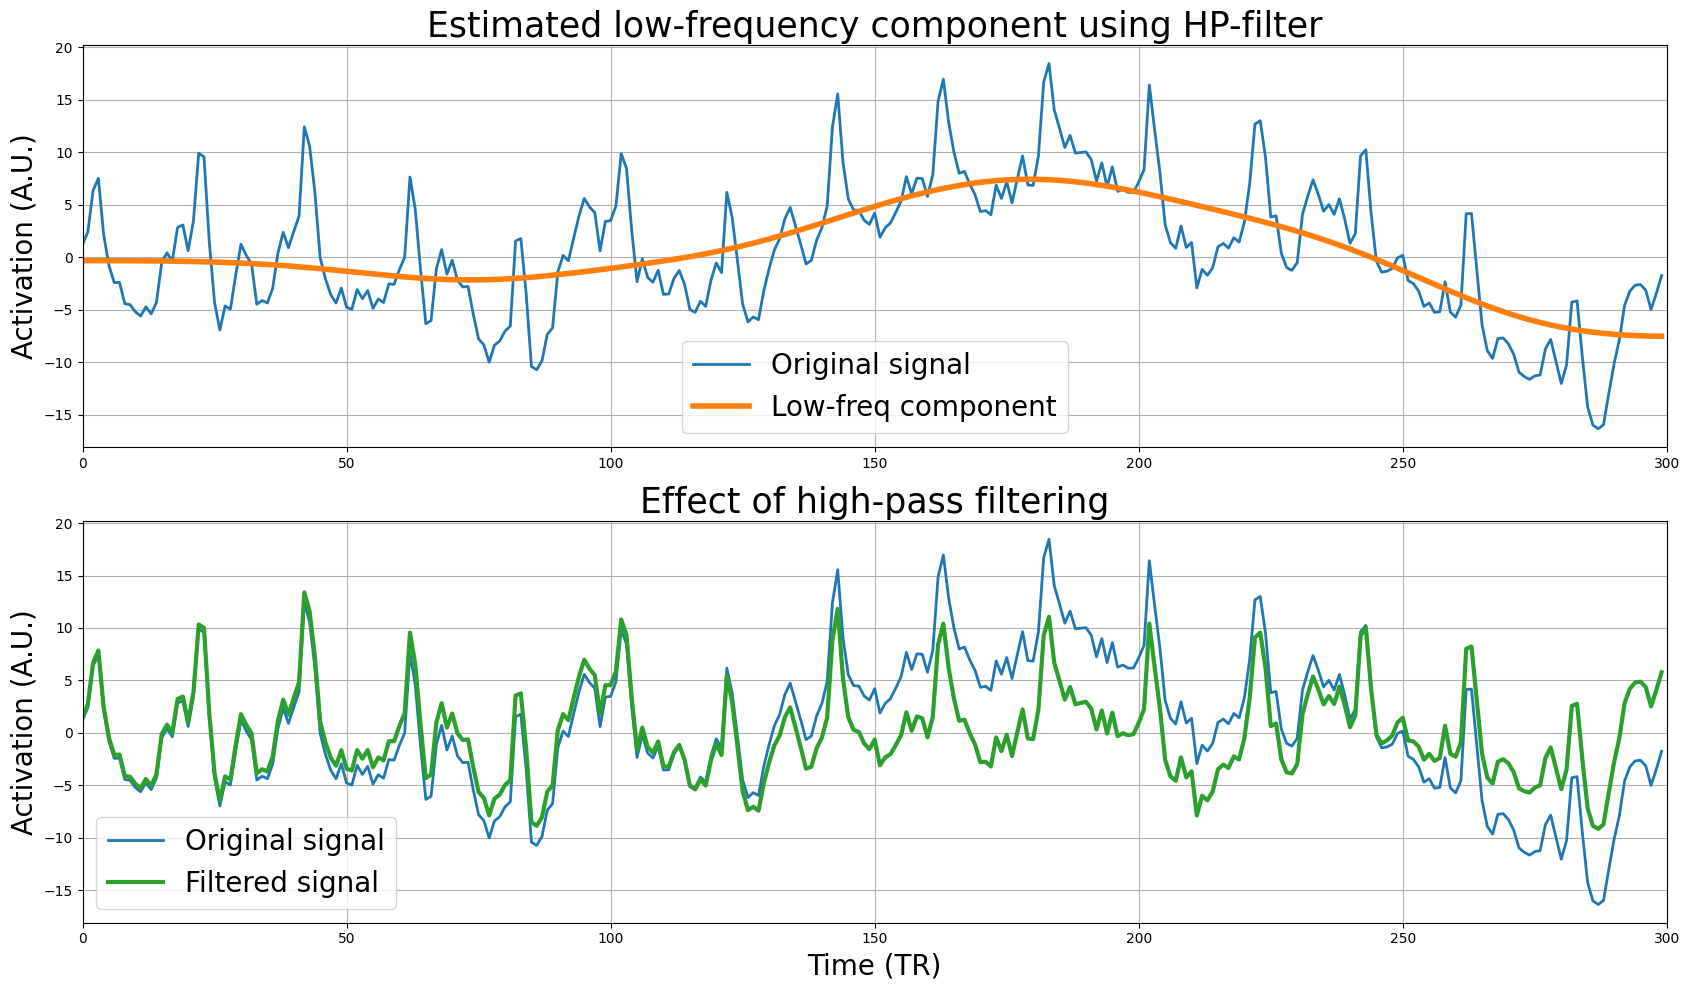

In [35]:
#Filter the original signal (called sig)
filt = gaussian_filter(sig, sigma_100)

plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
plt.plot(sig, lw=2)
plt.plot(filt, lw=4)
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Low-freq component'], fontsize=20)
plt.title("Estimated low-frequency component using HP-filter", fontsize=25)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

# IMPORTANT: subtract filter from signal
filt_sig = sig - filt

plt.subplot(2, 1, 2)
plt.plot(sig, lw=2)
plt.plot(filt_sig, lw=3, c='tab:green')
plt.xlim(0, sig.size)
plt.legend(['Original signal', 'Filtered signal'], fontsize=20)
plt.title("Effect of high-pass filtering", fontsize=25)
plt.xlabel("Time (TR)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

The signal looks much better, i.e., it doesn't display as much drift anymore. But let's check this by plotting the original and filtered signal in the frequency domain:

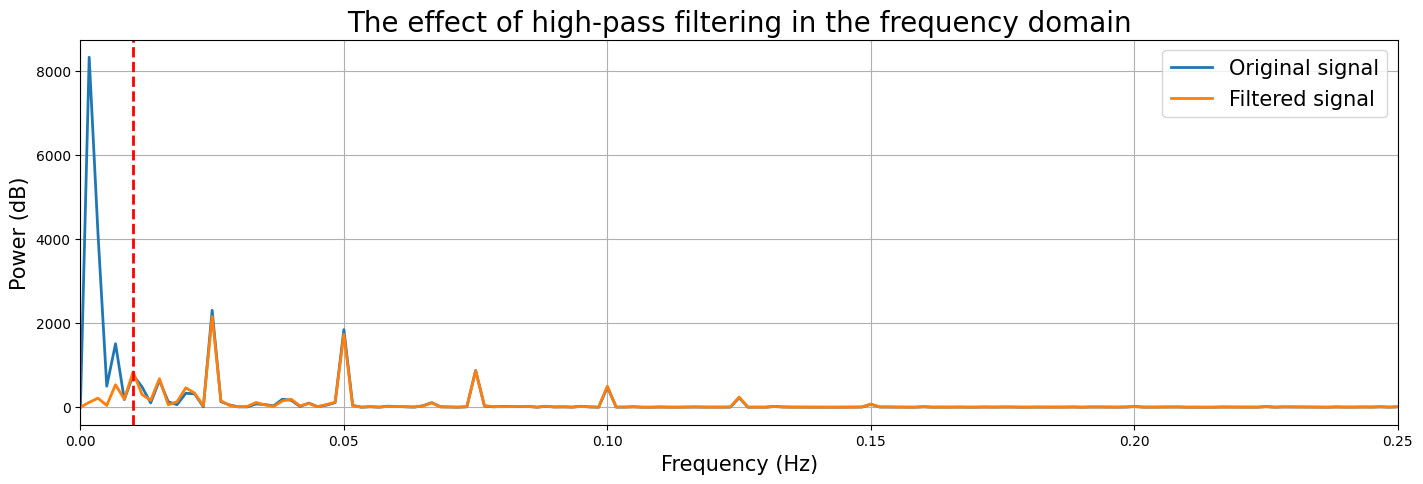

In [36]:
plt.figure(figsize=(17, 5))

freq, power = periodogram(sig, fs=0.5)
plt.plot(freq, power, lw=2)

freq, power = periodogram(filt_sig, fs=0.5)
plt.plot(freq, power, lw=2)
plt.axvline(x=0.01,color='r',ls='dashed', lw=2)
plt.xlim(0, freq.max())
plt.ylabel('Power (dB)', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.title("The effect of high-pass filtering in the frequency domain", fontsize=20)
plt.legend(["Original signal", "Filtered signal"], fontsize=15)
plt.grid()

plt.show()

Sweet! It seems that the high-pass filtering worked as expected! But does it really improve our model fit? To find out, we fit the same design (variable <tt>X</tt>) on the filtered signal (variable <tt>filt_sig</tt>) using linear regression. We calculate MSE and store it in the variable <tt>mse_with_filtering</tt> and compare it to the value for MSE without filter, we created above. (<tt>mse_without_filtering</tt>).

In [37]:
b = inv(X.T @ X) @ X.T @ filt_sig
mse_with_filtering = np.mean((filt_sig - X @ b) ** 2)
print("MSE without filtering:", mse_no_filtering)
print("MSE with filtering:", mse_with_filtering)

MSE without filtering: 32.31426158992288
MSE with filtering: 10.04999861859551



<b>Filtering real fMRI data</b>
    
So far, we've filtered only a single (simulated) voxel timeseries. Normally, you want to temporally filter *all* your voxels in your 4D fMRI data, of course. Below, we load in such a 4D fMRI file (<tt>data_4d</tt>), which has $50$ timepoints and ($80 \cdot 80 \cdot 44 = $) $281600$ voxels.

For this assignment, you need to apply the high-pass filter (i.e., the <tt>gaussian_filter</tt> function; use <tt>sigma=25</tt>) on each and every voxel separately, which means that you need to loop through all voxels (which amounts to three nested for-loops across all three spatial dimensions). Below, we've already loaded in the data. Now it's up to you write the loops (across spatial dimensions) to filter the signal in the inner-most loop and store it in the pre-allocated <tt>data_4d_filt</tt> variable (the loop may, if implemented correctly, take about 20 seconds!).


In [38]:

data_4d = nibabel.load(data_path / 'func.nii.gz').get_fdata()

print("Shape of the original 4D fMRI scan: %s" % (data_4d.shape,))

# Here, we pre-allocate a matrix of the same shape as data_4d, in which
# we will store the filtered timeseries
data_4d_filt = np.zeros(data_4d.shape)

# Start loop across X-dimension
for i in range(data_4d.shape[0]):

    # Start loop across Y-dimension
    for ii in range(data_4d.shape[1]):
        
        # Start loop across Z-dimension
        for iii in range(data_4d.shape[2]):
            # Filter the timeseries for voxel at location X=i, Y=ii, Z=iii and store it
            # using an appropriate index in the pre-allocated variable data_4d_filt!
            
            filtered_signal = gaussian_filter(data_4d[i, ii, iii, :], sigma=5)
            data_4d_filt[i, ii, iii, :] = data_4d[i, ii, iii, :] - filtered_signal

Shape of the original 4D fMRI scan: (80, 80, 44, 50)


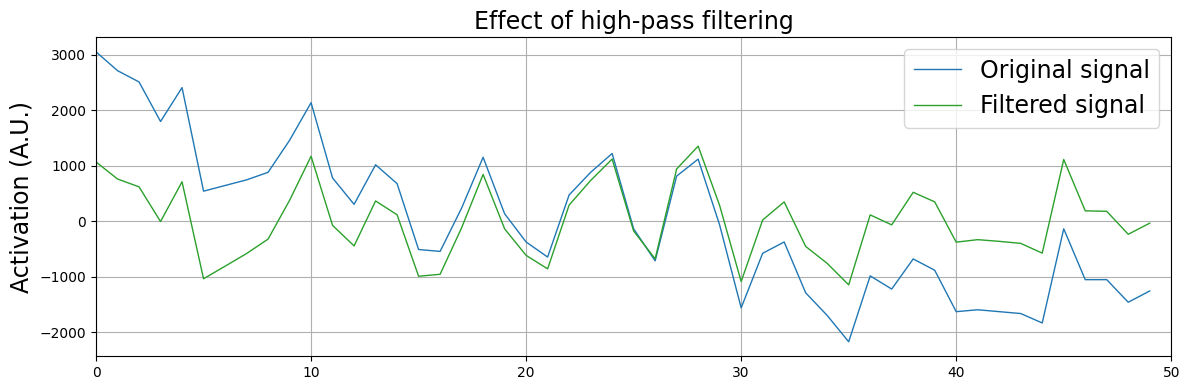

In [39]:

# Let's plot a random voxel to see the effect

plt.figure(figsize=(12, 4))


plt.plot(data_4d[40,40,42,:]-np.mean(data_4d[40,40,42,:]), lw=1)
plt.plot(data_4d_filt[40,40,42,:], lw=1, c='tab:green')
plt.xlim(0, 50)
plt.legend(['Original signal', 'Filtered signal'], fontsize=17)
plt.title('Effect of high-pass filtering', fontsize=17)
plt.ylabel("Activation (A.U.)", fontsize=17)
plt.grid()



plt.tight_layout()
plt.show()

<div class="alert alert-success">
    <b>Note</b>: when temporally filtering your fMRI data ($\mathbf{y}$), it is important to apply the <em>same filter</em> to your design matrix ($\mathbf{X}$)! This makes sure that your design matrix does not contain any "information" that is removed from the fMRI time series by the filter, anyway. Note that most neuroimaging software packages (including FSL) do this automatically.
    
Technically, by filtering each column (predictor) in your design matrix as well, you're orthogonalizing your design matrix with respect to your temporal high-pass filter. If you want to know more about this, check out <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24528">this excellent paper</a>.
</div>

### High-pass filtering of fMRI data (option 2)
As we've seen, high-pass filtering using a "running line smoother" is an operation that is applied to the signal directly (before model fitting) to reduce the noise term. Another way to reduce the noise term is to include *noise regressors* (also called 'nuisance variables/regressors') in the design matrix. As such, we can subdivide our design matrix into "predictors of interest" (which are included to model the task/stimuli) and "noise predictors" (which aim to model the thus-far unmodelled variance). These "noise predictors" are also sometimes called "nuisance" predictors/regressors/covariates. We can now slightly reformulate our linear regression equation by dividing our design into two components, $\mathbf{X}_{\mathrm{interest}}$ and $\mathbf{X}_{\mathrm{noise}}$:

\begin{align}
y = \mathbf{X}_{\mathrm{interest}}\beta_{\mathrm{interest}} + \mathbf{X}_{\mathrm{noise}}\beta_{\mathrm{noise}} + \epsilon
\end{align}

Importantly, the difference between $\mathbf{X}_{\mathrm{noise}}$ and $\epsilon$ is that the $\mathbf{X}_{\mathrm{noise}}$ term refers to noise-related activity that you *are able to model* while the $\epsilon$ term refers to the noise that you *can't model* (this is often called the "irreducible noise/error" term). 

We can use this technique, which we'll call "nuisance regression" (which we'll discuss in more detail later), as an alternative to directly high-pass filtering the signal ($\mathbf{y}$). One example of this (with respect to high-pass filtering) is including a series of cosines with varying frequencies in your design, which have the same effect as a high-pass filter. This type of filter is called a "discrete cosine (basis) set". Basically, for any given high-pass cutoff (in hertz), the "discrete cosine transform" (DTC) will yield a set of cosine regressors that is sufficient to filter out any frequency slower than your cutoff.

Fortunately, the `nilearn` package contains a function to calculate discrete cosine sets:

In [40]:
from nilearn.glm.first_level.design_matrix import _cosine_drift as discrete_cosine_transform

This function takes two arguments: `high_pass` (in hertz) and `frame_times` (an array with volume onsets). The signal from the previous examples (`sig`) was from an experiment lasting 600 seconds and with a TR of 2, so the volume onsets can be defined as follows:

In [41]:
frame_times = np.linspace(0, 600, 300, endpoint=False)

Now, let's compute a discrete cosine set for a highpass cutoff of 100 seconds (i.e., 0.01 hertz):

In [42]:
dc_set = discrete_cosine_transform(high_pass=0.01, frame_times=frame_times)
dc_set = dc_set[:, :-1]  # remove the (extra) intercept
print(sig.shape)
print(dc_set.shape)

(300,)
(300, 12)


As you can see, the function returns a numpy array with the same number of timepoints as our signal (300) and 12 predictors (we removed the last one, because that's an intercept). Note that it's not super important to know how, mathematically, a discrete cosine set is created; it's more important to understand the idea of adding these low-frequency cosine predictors to your design matrix in order to account for ("explain") the low-frequency parts of your data.

Let's plot the discrete cosine set that we created (note: we only plot the first 6 for clarity):

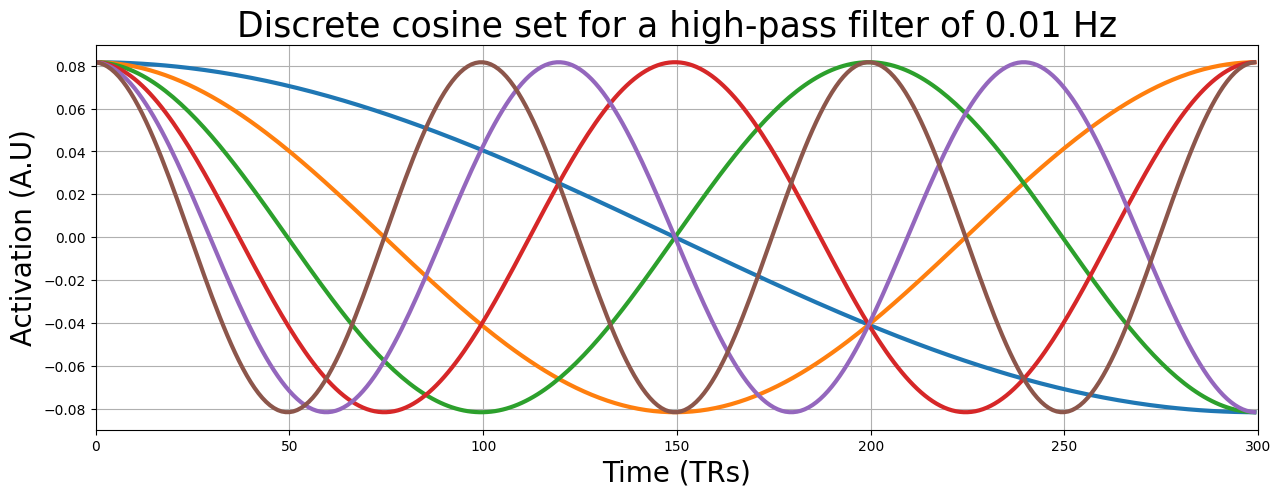

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(dc_set[:, :6], lw=3)
plt.xlim(0, sig.size)
plt.grid()
plt.title("Discrete cosine set for a high-pass filter of 0.01 Hz", fontsize=25)
plt.xlabel("Time (TRs)", fontsize=20)
plt.ylabel("Activation (A.U)", fontsize=20)
plt.show()


<b>Regression with models of slow wave signal</b>: 
- Let's add the discrete cosine set as predictors to the design (<tt>X</tt>) and store it in a new variable named <tt>X_dct</tt> (do *not* overwrite the <tt>X</tt> variable). 
We''l make sure the first two columns of <tt>X_dct</tt> are the original predictors from <tt>X</tt> followed by the DCT set. 
- Then, we will run linear regression and save the parameters ("betas") in a variable named <tt>betas_dct</tt>. 
- Plot the predicted signal ($\hat{\mathbf{y}}$) and the signal (<tt>sig</tt>) in the same plot.


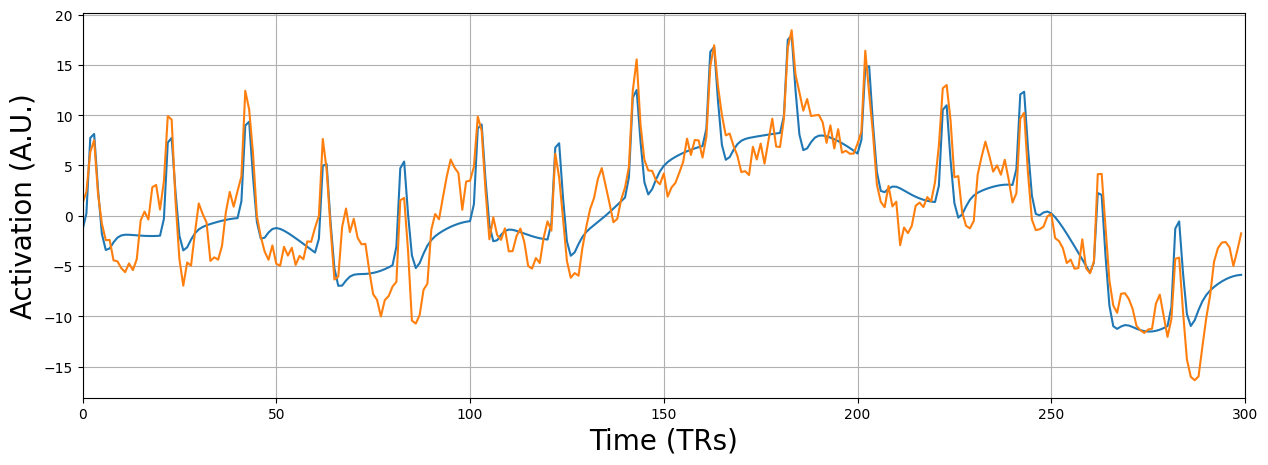

In [44]:

X_dct = np.hstack((X, dc_set))
betas_dct = inv(X_dct.T @ X_dct) @ X_dct.T @ sig

plt.figure(figsize=(15, 5))
plt.plot(X_dct @ betas_dct)
plt.plot(sig)
plt.xlim(0, sig.size)
plt.grid()
plt.xlabel("Time (TRs)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.show()


As you've seen, it doesn't really matter which strategy you choose, filtering the signal directly or adding nuisance regressors to the design: both (usually) work equally well.

## Autocorrelation and prewhitening 
As we have seen above, the model fit increases tremendously after high-pass filtering! This surely is the most important reason why you should apply a high-pass filter. But there is another important reason: high-pass filters reduce the signal's autocorrelation! 

"Sure, but why should we care about autocorrelation?", you might think? Well this has to with the estimation of the standard error of our model, i.e., $\hat{\sigma}^{2}\mathbf{c}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{c}^{T}$. The [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem) states that in order for OLS to yield valid estimates (including estimates of the parameters' standard errors) *the errors (residuals) have a mean of 0, have 0 covariance (i.e., are uncorrelated), and have equal variance*. 

Let's go through these three assumptions step by step. We'll use the previously filtered signal for this.

### Assumption of zero-mean of the residuals
First, let's check whether the mean of the residuals is zero:

In [45]:
b = inv(X.T @ X) @ X.T @ filt_sig
y_hat = X @ b
resids = filt_sig - y_hat
mean_resids = resids.mean()
print("Mean of residuals: %3.f" % mean_resids)

Mean of residuals:   0


<div class='alert alert-info'>
<b>ToThink3</b>: What component of the design-matrix ($\mathbf{X}$) ensures that the mean of the residuals is zero? Explain (concisely) why.
</div>

Write your answer to the ToThink3 question here: The intercept! This predictor makes sure that any constant variance ('offset') is modeled and thus cannot occur in the residuals.

### Equal variance of the residuals
Alright, sweet &mdash; the first assumption seems valid for our data. Now, the next two assumptions &mdash; about equal variance of the residuals and no covariance between residuals &mdash; are trickier to understand and deal with. These assumptions can be summarized in a single mathemtical statement: the covariance-matrix of the residuals should not differ substantially from the identity-matrix ($\mathbf{I}$) scaled by the noise-term ($\hat{\sigma}^{2}$). Or, put in a formula:

\begin{align}
\mathrm{cov}[\epsilon] = \hat{\sigma}^{2}\mathbf{I}
\end{align}

This sounds difficult, so let's break it down. First off all, the covariance matrix of the residuals is always a symmetric matrix of shape $N \times N$, in which the *diagonal represents the variances* and the *off-diagonal represents the covariances*. For example, at index $[i, i]$, the value represents the variance of the residual at timepoint $i$. At index $[i, j]$, the value represents the covariance between the residuals at timepoints $i$ and $j$. 

In OLS, we assume that the covariance matrix of the residuals ($\mathrm{cov}[\epsilon]$) matches the 
identity-matrix ($\mathbf{I}$) times the noise-term ($\hat{\sigma}^{2}$). The identity-matrix is simply a matrix with all zeros except for the diagonal, which contains ones. For example, the identity-matrix for a residual-array of length $8$ looks like:

In [46]:
identity_mat = np.eye(8)  # makes an "eye"dentity matrix
print(identity_mat)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


We can also represent this visually:

Text(0.5, 1.0, 'Assumed covariance matrix of residuals')

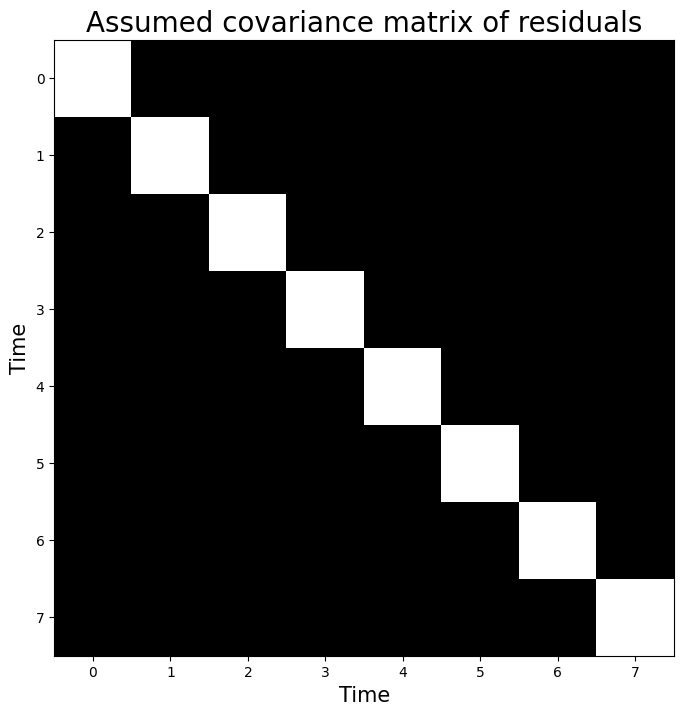

In [47]:
plt.figure(figsize=(8, 8))
plt.imshow(identity_mat, cmap='gray', aspect='auto')
plt.xlabel("Time", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.title("Assumed covariance matrix of residuals", fontsize=20)

Now, suppose we calculated that the noise-term of a model explaining this hypothetical signal of length $8$ equals 2.58 ($\hat{\sigma}^{2} = 2.58$). Then, OLS *assumes* that the noise stems from a covariance matrix estimated from the residuals:

In [24]:
noise_term = 2.58
assumed_cov_resid = noise_term * identity_mat
print(assumed_cov_resid)

[[2.58 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   2.58 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   2.58 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   2.58 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   2.58 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   2.58 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   2.58 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   2.58]]


In other words, this assumption about the covariance matrix of the residuals states that the *variance across residuals (the diagonal of the matrix) should be equal* and the *covariance between residuals (the off-diagonal values of the matrix) should be 0* (in the population).

Now, we won't explicitly estimate the covariance matrix of the residuals (which is usually estimated using techniques that fall beyond the scope of this course); however, we *do* want you to understand *conceptually* how fMRI data might invalidate the assumptions about the covariance matrix of the residuals and how fMRI analyses deal with this (i.e., using prewhitening, which is explained later). 

So, let's check *visually* whether the assumption of equal variance of our residuals roughly holds for our (simulated) fMRI data. Now, when we consider this assumption in the context of our fMRI data, the assumption of "equal variance of the residuals" (also called homoskedasticity) means that we assume that the "error" in the model is equally big across our timeseries data. In other words, the mis-modelling (error) should be constant over time.

Let's check this for our data:

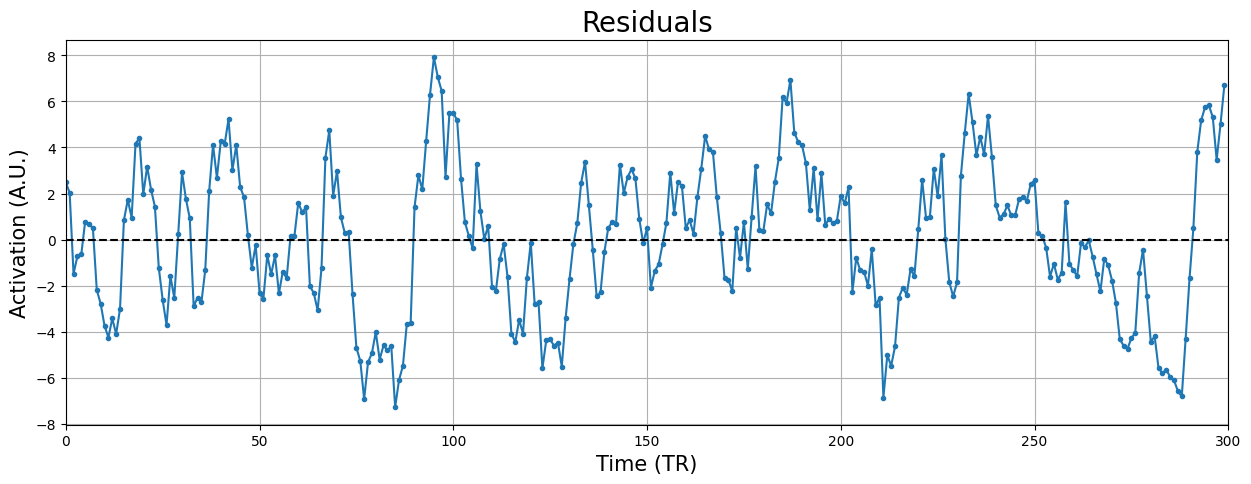

In [48]:
plt.figure(figsize=(15, 5))
plt.plot(resids, marker='.')
plt.xlim(0, resids.size)
plt.xlabel("Time (TR)", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=15)
plt.title("Residuals", fontsize=20)
plt.axhline(0, ls='--', c='black')
plt.grid()
plt.show()

Looks quite alright! Sure, there is some variation here and there, but given that our estimates (including the residuals and their variance!) are imperfect, this suffices. 

Just to give you some intuition about serious issues with homoskedasticity, check out the (hypothetical) timeseries residuals below:

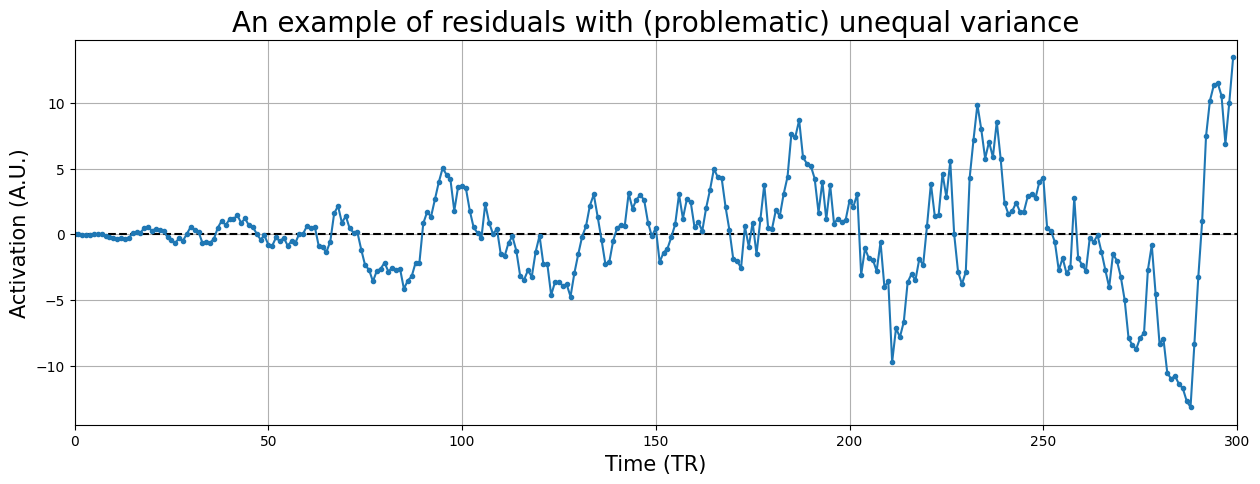

In [49]:
# Creating a vector of growing numbers
mfactor = np.linspace(0, 2, sig.size)
# Multiply this with our residuals to make them change size over time
example_resids = resids * mfactor

plt.figure(figsize=(15, 5))
plt.xlim(0, sig.size)
plt.xlabel("Time (TR)", fontsize=15)
plt.ylabel("Activation (A.U.)", fontsize=15)
plt.title("An example of residuals with (problematic) unequal variance", fontsize=20)
plt.axhline(0, ls='--', c='black')
plt.plot(example_resids, marker='.')
plt.grid()
plt.show()

<div class='alert alert-info'> 
<b>ToThink4</b>: What could cause unequal variance in the residuals of an fMRI signal, *given that autocorrelation (i.e. low-frequency components) is filtered out appropriately*? In other words, can you think of something that might cause larger (or smaller) errors across the duration of an fMRI run (solution at the end of the notebook)?
</div>

Write your answer to the ToThink4 question here: One reason could be that the noise becomes larger (the signal becomes weaker) due to increasing inhomogeneities of the magnetic field caused by, for example, subject movement. Another cause could be that subjects stop paying attention or do other things that might increase the noise over time. Note: things that cause *drift* do not necessarily lead to unequal variance across time!

### Zero covariance between residuals
The last assumption of zero covariance between residuals (corresponding to the assumption of all zeros on the off-diagonal elements of the covariance-matrix of the residuals) basically refers to the assumption that *there is no autocorrelation (correlation in time) in the residuals*. In other words, knowing the residual at timepoint $i$ does not tell you anything about the residual at timepoint $i+\tau$, where $\tau$ reflects a particular "lag" and can be any positive number (up to $N$). For example, the "lag 1" autocorrelation ($\tau = 1$) is the correlation between the data at timepoints $i$ and $i+1$. In OLS, we assume that there is no autocorrelation across all possible lags.

Take for example the residuals of our unfiltered signal from before, which looked like:

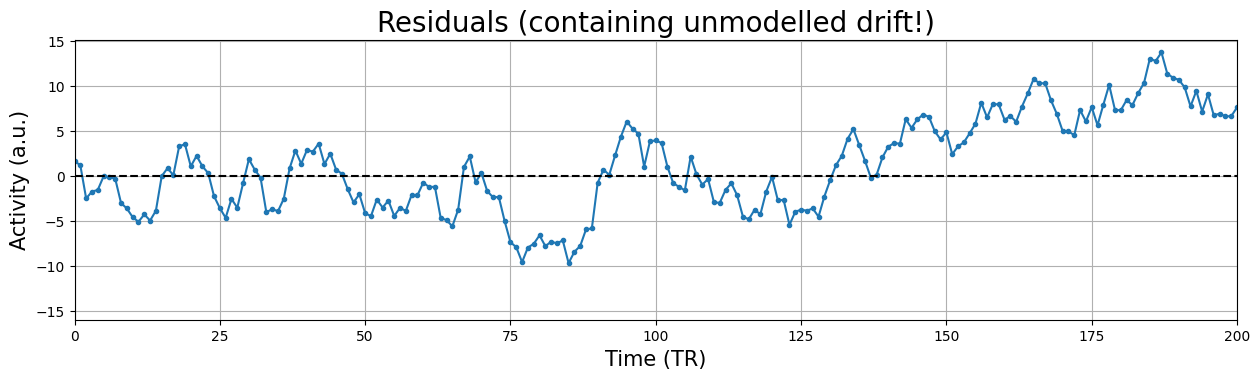

In [50]:
b = inv(X.T @ X) @ X.T @ sig
resids_new = sig - X @ b

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(resids_new, marker='.')
plt.axhline(0, ls='--', c='black')
plt.xlim(0, 200)
plt.xlabel("Time (TR)", fontsize=15)
plt.title('Residuals (containing unmodelled drift!)', fontsize=20)
plt.ylabel('Activity (a.u.)', fontsize=15)
plt.grid()
plt.show()

In the above plot, there is clear and strong autocorrelation in the residuals. For example, the residuals are overall getting larger across time ("drift") and it contains other low-frequency (oscillatory) patterns. As such, we *do know something about the residual at timepoint $i+1$ (and other lags) given the residual at timepoint $i$, namely that it is likely that the residual at timpoint $i+1$ is likely __higher__ than the residual at timepoint $i$*! Therefore, drift is a perfect example of something that (if not modelled) causes autocorrelation in the residuals (i.e. covariance between residuals)! In other words, autocorrelation (e.g. caused by drift) will cause the values of the covariance matrix of the residuals at the indices $[i, i+1]$ to be non-zero, violating the third assumption of Gauss-Markov's theorem!

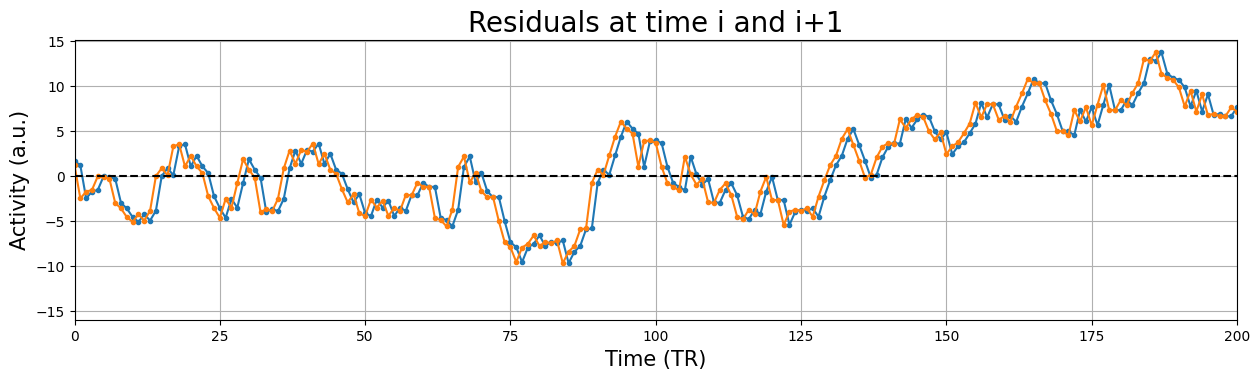

In [51]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(resids_new[:-1], marker='.') # index ends one before end (-1)
plt.plot(resids_new[1:], marker='.') # index starts at 1 (second datapoint due to zero-indexing)
plt.axhline(0, ls='--', c='black')
plt.xlim(0, 200)
plt.xlabel("Time (TR)", fontsize=15)
plt.title('Residuals at time i and i+1', fontsize=20)
plt.ylabel('Activity (a.u.)', fontsize=15)
plt.grid()
plt.show()


<b>Calculating autocorrelation</b> 
    
We stated that autocorrelation captures the information that you have of the residual at timepoint $i+\tau$ given that you know the residual at timepoint $i$. Practically, you can compute the autocorrelation (or actually, autocovariance) for a particular lag $\tau$ by computing the covariance of the residuals with the lag-$\tau$ shifted version of itself. In general, the autocovariance for the residuals $\epsilon$ with lag $\tau$ is calculated as:

\begin{align}
\mathrm{cov}[\epsilon_{i}, \epsilon_{i+\tau}] = \frac{1}{N-\tau-1}\sum_{i=1}^{N-\tau}(\epsilon_{i}\cdot\epsilon_{i+\tau})
\end{align}
 
<div class='alert alert-success'>


 
Jeanette Mumford explains how to do this quite clearly in her [video on prewhitening](https://www.youtube.com/watch?v=4VSzZKO0k_w) (around minute 10). 
</div>    

Here, we will calculate the covariance (with $\tau = 1$) between the residuals (i.e., using the variable <tt>resids_new</tt>) and store this in a variable named <tt>lag1_cov</tt>.


In [52]:

tau = 1
lag1_cov = resids_new[:-1] @ resids_new[1:] / (resids_new.size - tau - 1)
print(lag1_cov)


31.19064650915883


### Accounting for unequal variance and autocorrelation: prewhitening
So, in summary, if the covariance matrix of your residuals appear to significantly deviate from the identity-matrix scaled by the noise-term ($\mathrm{cov}[\epsilon] = \hat{\sigma}^{2}\mathbf{I}$) &mdash; either due to unequal variance or non-zero covariance &mdash; your estimate of the variance term of your effects ($\mathrm{var}[c\hat{\beta}]$) will be incorrect. 

Unfortunately, even after high-pass filtering (which corrects for *most* but not *all* autocovariance), the covariance matrix of the residuals of fMRI timeseries usually do no conform to the Markov-Gauss assumptions of equal variance and zero covariance. Fortunately, some methods have been developed by statisticians that transform the data such that the OLS assumptions hold again. One such technique is called *prewhitening*. 

Prewhitening uses an estimate of the error covariance matrix &mdash; usually denoted by $\mathbf{V}$ &mdash; to account for possible unequal variance and/or autocovariance of the residuals. The matrix $\mathbf{V}$ is an $N \times N$ matrix ($N$ referring to the number of timepoints of your signal), and  may be estimated using different techniques, with names such as "ARMA", "AR(1)", and "REML".


<b>AR(1) modelling of autocorrelation</b>
    
The "AR(1)" method is a relatively "easy" way to estimate $\mathbf{V}$. It computes only a single parameter, the lag-1 correlation (not covariance!). Then, it assumes that the correlation decreases exponentially as a function of lag:

\begin{align}
\mathrm{autocor}_{\tau} = \phi^{\tau + 1}
\end{align}

where $\phi$ is the estimated lag-1 correlation. For example, for $\phi = 0.9$, $\mathbf{V}$ would look like:

\begin{align}
\mathbf{V} = \begin{bmatrix}
                 1.0 & 0.9 & 0.9^{2} & 0.9^{3} & \dots & 0.9^{N-1} \\
                 0.9 & 1.0 & 0.9 & 0.9^{2} & \dots & 0.9^{N-2} \\
                 0.9^{2} & 0.9 & 1.0 & 0.9 & \dots & 0.9^{N-3} \\
                 0.9^{3} & 0.9^{2} & 0.9 & 1.0 & \dots & 0.9^{N-4} \\
                 \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
                 0.9^{N-1} & 0.9^{N-2} & 0.9^{N-3} & 0.9^{N-4} & \dots & 1.0
             \end{bmatrix}
\end{align}

Let's now compute the lag-1 correlation below and create the corresponding AR(1) matrix of the residuals (<tt>resids_new</tt>) and store this in a variable named <tt>V_ar1</tt> .
</div>

Text(0.5, 1.0, 'AR(1) matrix')

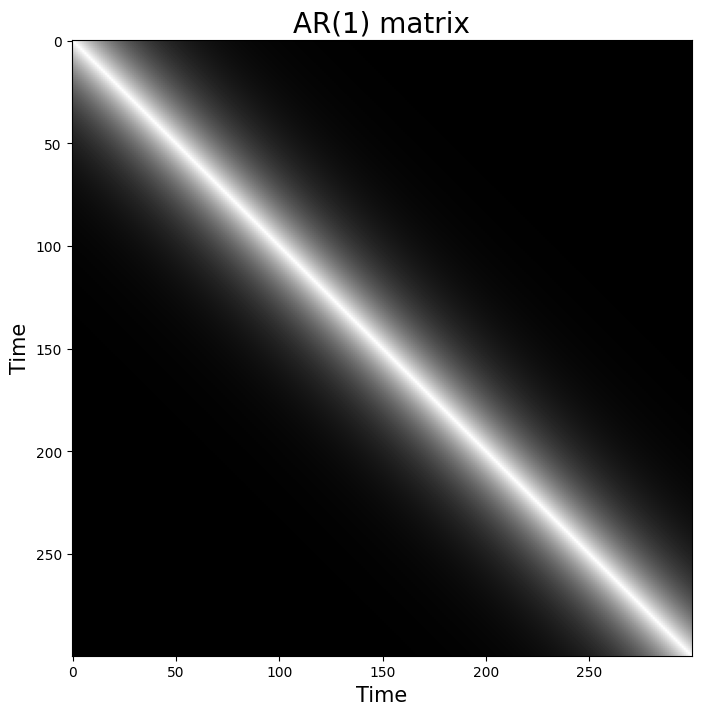

In [55]:
#Rename residuals and residuals at time-lag i+1
t0, t1 = resids_new[:-1], resids_new[1:]
# Calculate the correlation (ie. the scaled covariance) between t0 and t1 (demeaned). 
lag1_cor = (t0 - t0.mean()) @ (t1 - t1.mean()) / np.sqrt(np.sum((t0 - t0.mean()) ** 2) * np.sum((t1 - t1.mean()) ** 2))
V_ar1 = np.eye(resids_new.size)
for i in range(1, resids_new.size):
    idx_x = np.arange(0, resids_new.size-i)
    idx_y = np.arange(i, resids_new.size)
    V_ar1[idx_x, idx_y] = lag1_cor ** i
    V_ar1[idx_y, idx_x] = lag1_cor ** i

#Let's plot it as an image
plt.figure(figsize=(8, 8))
plt.imshow(V_ar1, cmap='gray', aspect='auto')
plt.xlabel("Time", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.title("AR(1) matrix", fontsize=20)

Suppose you have a signal of 20 timepoints (an irrealistically low number, but just ignore that for now) and that you already estimated the covariance matrix of the residuals of this signal. Now, suppose you take a look at it and you notice that it looks faaaaar from the identity-matrix ($\mathbf{I}$) that we need for OLS.

For example, you might see this:

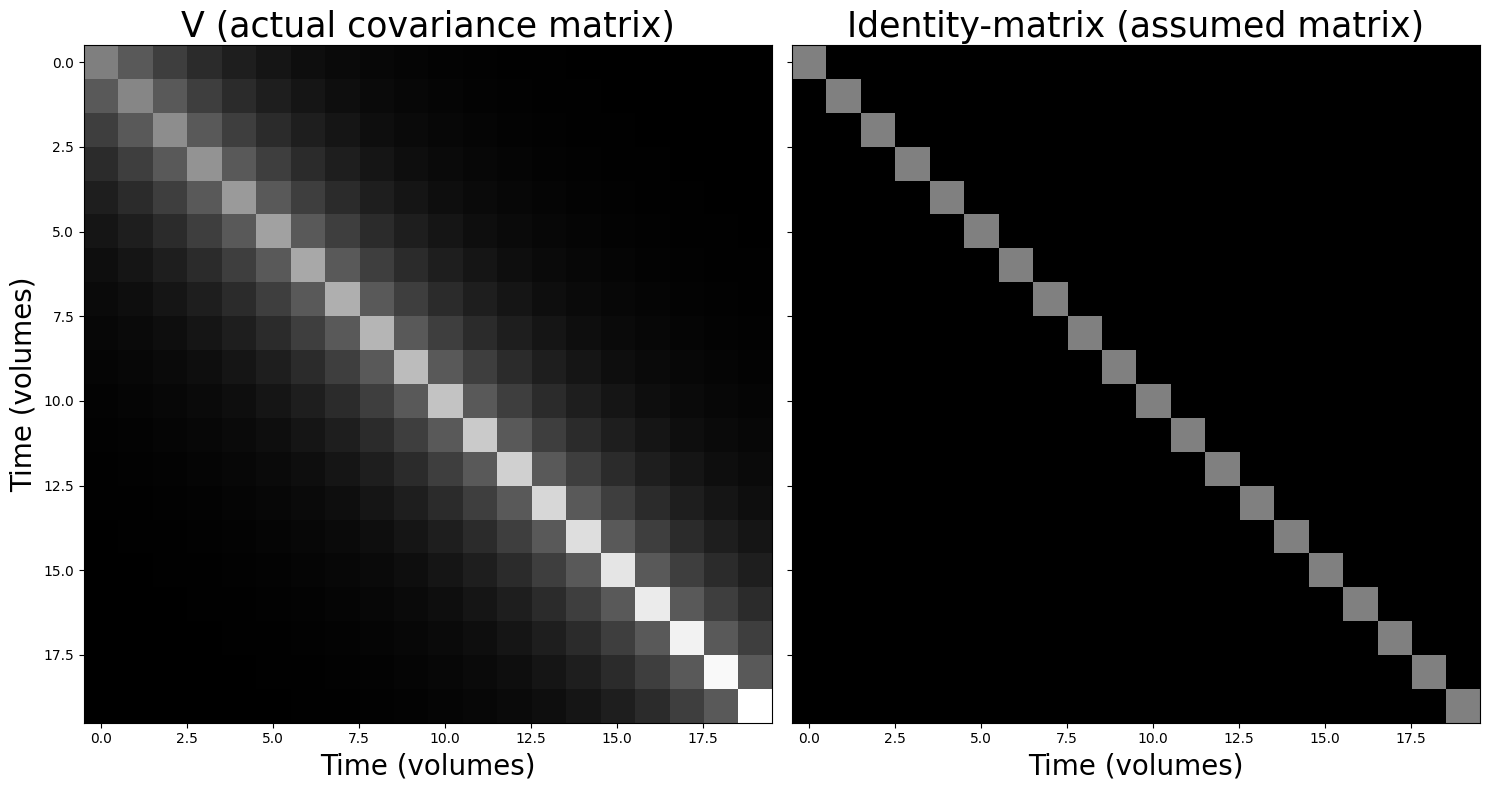

In [56]:
N = 20
phi = 0.7
V = phi ** toeplitz(np.arange(N))
# This will increase variance over time
V[np.diag_indices_from(V)] += np.linspace(0, 1, V.shape[0])

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 8))
axes[0].imshow(V, vmax=2, cmap='gray', aspect='auto')
axes[0].set_title("V (actual covariance matrix)", fontsize=25)
axes[0].set_xlabel('Time (volumes)', fontsize=20)
axes[0].set_ylabel('Time (volumes)', fontsize=20)

axes[1].imshow(np.eye(N), vmax=2, cmap='gray', aspect='auto')
axes[1].set_title("Identity-matrix (assumed matrix)", fontsize=25)
#axes[1].colorbar()
axes[1].set_xlabel('Time (volumes)', fontsize=20)

fig.tight_layout()

Well, shit. We have both unequal variance (different values on the diagonal) *and* non-zero covariance (some non-zero values on the off-diagonal). So, what to do now? Well, we can use the technique of prewhitening to make sure our observed covariance matrix ($\mathbf{V}$) will be "converted" to the identity matrix! Basically, this amounts to plugging in some extra terms to formula for ordinary least squares. As you might have seen in stats books/videos, the *original* [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) solution (i.e., how OLS finds the beta-parameters is as follows):

\begin{align}
\hat{\beta} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}y
\end{align}

Now, given that we've estimated our covariance matrix of the residuals, $\mathbf{V}$, we can rewrite the OLS solution such that it prewhitens the data (and thus the covariance matrix of the residuals will approximate $\hat{\sigma}^{2}\mathbf{I}$) as follows:

\begin{align}
\hat{\beta} = (\mathbf{X}^{T}\mathbf{V}^{-1}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{V}^{-1}y
\end{align}

Then, accordingly, the standard-error of any contrast of the estimated beta-parameters becomes:

\begin{align}
SE_{\mathbf{c}\hat{\beta}} = \sqrt{\hat{\sigma}^{2} \cdot \mathbf{c}(\mathbf{X}^{T}\mathbf{V}^{-1}\mathbf{X})^{-1}\mathbf{c}^{T}}
\end{align}

This "modification" of OLS is also called "generalized least squares" (GLS) and is central to most univariate fMRI analyses! You *don't* have to understand how this works mathematically; again, you should only understand *why* prewhitening makes sure that our data behaves according to the assumptions of the [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss–Markov_theorem).

(Fortunately for us, there is usually an option to 'turn on' prewhitening in existing software packages, so we don't have to do it ourselves. But it is important to actually turn it on whenever you want to meaningfully and in an unbiased way interpret your statistics in fMRI analyses!)


<b>Implementation of GLS</b>: Given the target signal (<tt>some_sig</tt>), design-matrix (<tt>some_X</tt>), and the (hypothetical) covariance-matrix of the residuals from before (the variable <tt>V</tt>), let's calculate the beta-parameters using the prewhitened version of OLS (i.e., 'generalized least squares'; the formula above). Also, let's calculate the $t$-value of the contrast <tt>[0, 1]</tt> given the appropriate (GLS) computation of the standard-error and store our results in the variable <tt>betas_gls</tt> and <tt>tval_gls</tt>, respectively.
</div>

In [57]:

some_sig = sig[:20]  # y
some_X = X[:20, :]   # X
c_vec = np.array([0, 1])  # the contrast you should use


betas_gls = inv(some_X.T @ inv(V) @ some_X) @ some_X.T @ inv(V) @ some_sig
sigmasq_hat = np.sum((some_sig - some_X @ betas_gls) ** 2) / (some_X.shape[0] - some_X.shape[1])
desvar = c_vec @ inv(some_X.T @ inv(V) @ some_X) @ c_vec.T
tval_gls = c_vec.dot(betas_gls) / np.sqrt(sigmasq_hat * desvar)



<b>Investigating OLS with simulated data</b>

When it comes to estimating parameters from data with unequal (co)variance, OLS actually still gives you unbiased parameters: on average, they will be correct. However, OLS is not the estimator with least variance anymore, meaning that it is less "precise" (it is not the "Best Linear Unbiased Estimator" anymore; still unbiased, but not the "best"). In fact, with unequal (co)variance, GLS is the best unbiased linear estimator. A good way to build intuition about this is to iteratively generate data with known parameters (the "true betas", $\beta$, "sigma squared", $\sigma^{2}$, and $V$) and to estimate the parameters back from the generated data. Then, you can plot the histograms of the parameters and you'll see that, on average, the estimated parameters are the same as the true parameters.

Below, we set up such a "simulation" loop for you. We define the true parameters (<tt>true_betas</tt>, <tt>siqsq</tt>, <tt>V</tt>). Next, we will complete the loop by:
1. Generating some random design matrix (e.g., using <tt>np.random.normal</tt> of size (N, 1));
2. Stack an intercept
3. Generate correlated noise using the <tt>np.random.multivariate_normal</tt> function (with <tt>cov=V</tt>);
4. Generate the data using the formula $X\beta + \mathrm{noise}$;
5. Estimate the OLS parameters, and store in <tt>betas_ols</tt>;
6. Estimate the GLS parameters, and store in <tt>betas_gls</tt>;
7. In the next cell, plot both parameters (<tt>betas_ols[:, 1]</tt> and <tt>betas_gls[:, 1]</tt>) as histograms



In [58]:
true_betas = np.array([0, 1])
iters = 100

N = 50
phi = 0.8  # AR1 parameter
sigsq = 2
V = sigsq * phi ** toeplitz(np.arange(N))

betas_ols = np.zeros((iters, 2))
betas_gls = np.zeros((iters, 2))

for i in range(iters):
    
    # Generate data
    Xn = np.random.normal(0, 1, size=N)
    icept = np.ones(N)
    Xn = np.c_[icept, Xn]
    noise = np.random.multivariate_normal(mean=np.zeros(N), cov=V)
    y = Xn @ true_betas + noise
    
    # Estimate parameters
    betas_ols[i, :] = inv(Xn.T @ Xn) @ Xn.T @ y
    betas_gls[i, :] = inv(Xn.T @ inv(V) @ Xn) @ Xn.T @ inv(V) @ y
    

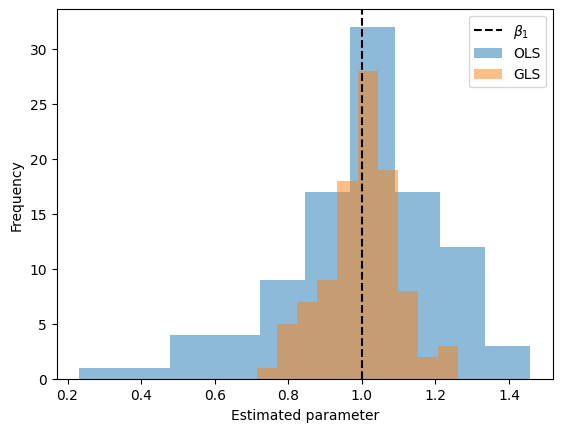

In [59]:
plt.axvline(true_betas[1], ls='--', c='k')
plt.hist(betas_ols[:, 1], alpha=0.5)
plt.hist(betas_gls[:, 1], alpha=0.5)

plt.legend([r'$\beta_{1}$', 'OLS', 'GLS'])
plt.xlabel("Estimated parameter")
plt.ylabel("Frequency")
plt.show()

Do the histograms look like you expected? Also, try changing the <tt>phi</tt> parameter, which controls the amount of autocorrelation in the data (it's the AR1 parameter which is used to create <tt>V</tt>). What happens to the difference between OLS and GLS?


## (More on) nuisance regression
Let's go back to the technique of nuisance regression. We have seen before that this technique can be used to model low-frequency components in our data (effectively functioning as a high-pass filter), but it can, in general, be used to model *any* thus-far unmodelled variance in the signal that would otherwise end up in the noise term. For example, people use this technique to model variance due to physiological processes (such cardiac and respiratory related signals; see e.g. [Glover et al., 2000](https://www.ncbi.nlm.nih.gov/pubmed/10893535)), motion-related variance (which we'll discuss later), and high-intensity "spikes". To get a better feel for nuisance regression and its consequences, let's look at this process of removing high-intensity spikes (which is sometimes called "despiking").

### Using nuisance regression for despiking
This technique of adding noise-predictors to the design matrix is sometimes used to model 'gradient artifacts', which are also called 'spikes'. This technique is also sometimes called "despiking". These spikes reflect sudden large intensity increases in the signal across the entire brain that likely reflect scanner instabilities. One way to deal with these artifacts is to "censor" bad timepoints (containing the spike) in your signal using a noise predictor.

But what defines a 'spike'/bad timepoint? One way is to compute the normalized "root mean square successive differences" (RMSSD), normalizing this, and imposing some threshold above which a timepoint is marked as a spike (technically, it's a little bit more complex, but we'll ignore that for now).

We'll delve into the details of this computation later. For now, let's take a look at some example data that we're going to use for this section:

In [61]:
with np.load(data_path / 'spike_data.npz') as spike_data:
    all_sig = spike_data['all_sig']
    pred = spike_data['pred']

print("Shape of all_sig: %s" % (all_sig.shape,))
print("Shape of pred: %s" % (pred.shape,))

Shape of all_sig: (10, 10, 10, 500)
Shape of pred: (500, 1)


The example data `all_sig` is a (simulated) 4D fMRI scan with $10 \times 10 \times 10$ voxels and 500 timepoints (assuming a TR of 2, this amounts to a duration of 1000 seconds). The predictor reflects a design in which the participants was shown a stimulus every 100 seconds (50 TRs). Let's plot the predictor:

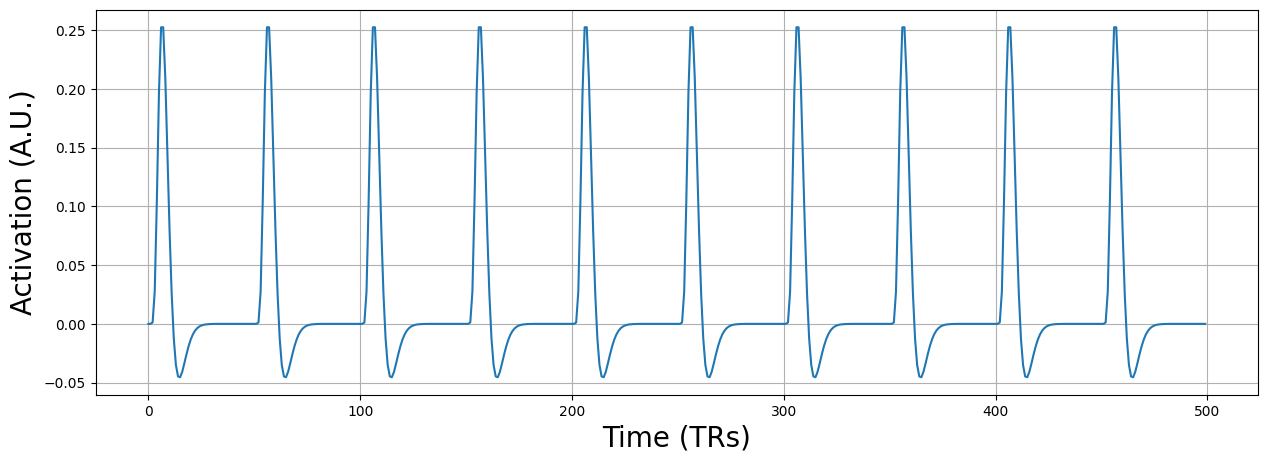

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(pred)
plt.grid()
plt.xlabel('Time (TRs)', fontsize=20)
plt.ylabel('Activation (A.U.)', fontsize=20)
plt.show()

Alright, now let's take a look at how you would calculate the "root mean square successive differences" (RMSSD). This quantity reflects the difference between every timepoint $t$ of your signal and the signal at timepoints $t-1$, which is then squared, averaged (across all voxels, $1 \dots K$), after which the square root is taken:

\begin{align}
\mathrm{RMSSD}_{t} = \sqrt{\frac{1}{K}\sum_{K}(s_{t, k} - s_{t-1, k})^2}
\end{align}

First, let's focus on the "successive differences". Suppose we have only one "signal" of length 5:

In [63]:
ex_sig = np.array([1, 3, -2, 0, 5])

The "successive differences" are the difference between 3 and 1, -2 and 3, 0 and -2, and 5 and 0. Note that the successive difference for the first timepoint ($t=0$) is not defined! In code, we can compute this with:

In [64]:
succ_diff = ex_sig[1:] - ex_sig[:-1]
print(succ_diff)

[ 2 -5  2  5]


After computing the successive differences, we need to do another thing. As we noted earlier, RMSSD is not defined for $t=0$ (because there is no $t-1$ for the first timepoint). We can insert a duplicate of the first value here for convenience. 

In [65]:
succ_diff = np.insert(succ_diff, 0, succ_diff[0])

Now, we will compute the RMSSD of the simulated spike data. Note that our data (<tt>all_sig</tt>) has 4 dimensions, with the fourth dimension representing time. We'll store the result in a variable named <tt>all_sig_rmssd</tt>, which should have the same shape as the original signal. We will do this without a for-loop by making using of vectorization.
</div>

In [66]:

all_sig_sd = all_sig[:, :, :, 1:] - all_sig[:, :, :, :-1]
all_sig_rmssd = np.sqrt(np.mean(all_sig_sd ** 2, axis=(0, 1, 2)))
all_sig_rmssd = np.insert(all_sig_rmssd, 0, all_sig_rmssd[0])



Now, in order to identify spikes, we need to identify timepoints that have a RMSSD-values that differ more than (let's say) 7 standard deviations from the mean RMSSD value. As such, you need to 'z-score' the RMSSD values: subtract the mean value from each individual value and divide each of the resulting 'demeaned' values by the standard deviation ($\mathrm{std}$) of the values. In other words, the z-transform of any signal $s$ with mean $\bar{s}$ is defined as:

\begin{align}
z(s) = \frac{(s - \bar{s})}{\mathrm{std}(s)}
\end{align}

We will implement this z-score transform for the variable <tt>all_sig_rmssd</tt> and store it in the variable <tt>z_rmssd</tt> (1 point). Then, plot the z-scored RMSSD signal. 
</div>

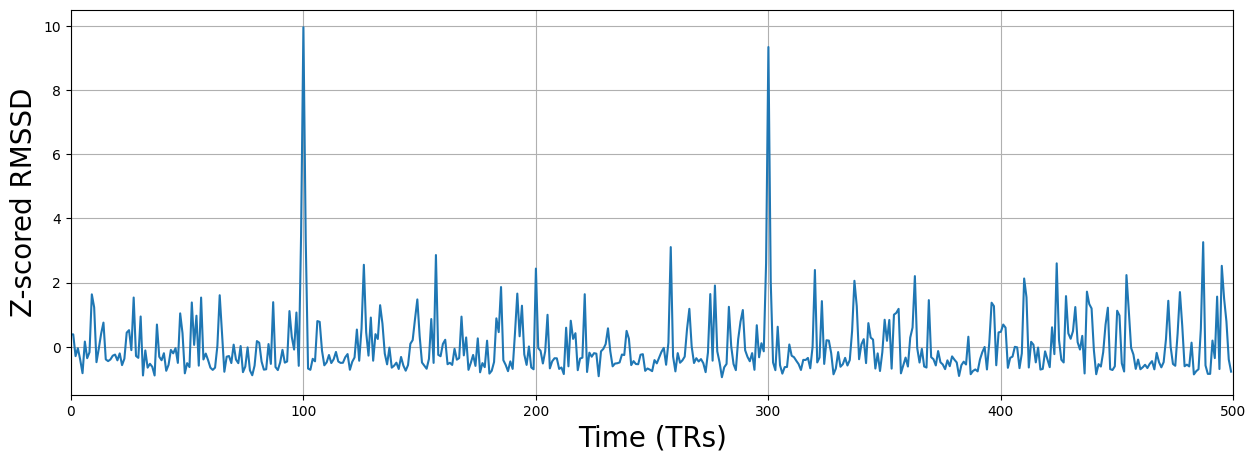

In [67]:

z_rmssd = (all_sig_rmssd - all_sig_rmssd.mean()) / all_sig_rmssd.std()

plt.figure(figsize=(15, 5))
plt.plot(z_rmssd)
plt.grid()
plt.xlabel("Time (TRs)", fontsize=20)
plt.ylabel("Z-scored RMSSD", fontsize=20)
plt.xlim(0, z_rmssd.size)
plt.show()

Now, we can set a threshold above which we define timepoints as "spikes". Let's say we do this for $z > 7$.

In [68]:

identified_spikes = z_rmssd > 7  # creates array with True/False
n_spike = identified_spikes.sum()
print("There are %i spikes in the data!" % n_spike)

There are 2 spikes in the data!


Now, to remove this influence, we can simply add a nuisance predictor for each spike, in which the predictor contains zeros at timepoints without the spike and 1 at the timepoint with a spike.

Creating spike predictor for t = 100
Creating spike predictor for t = 300


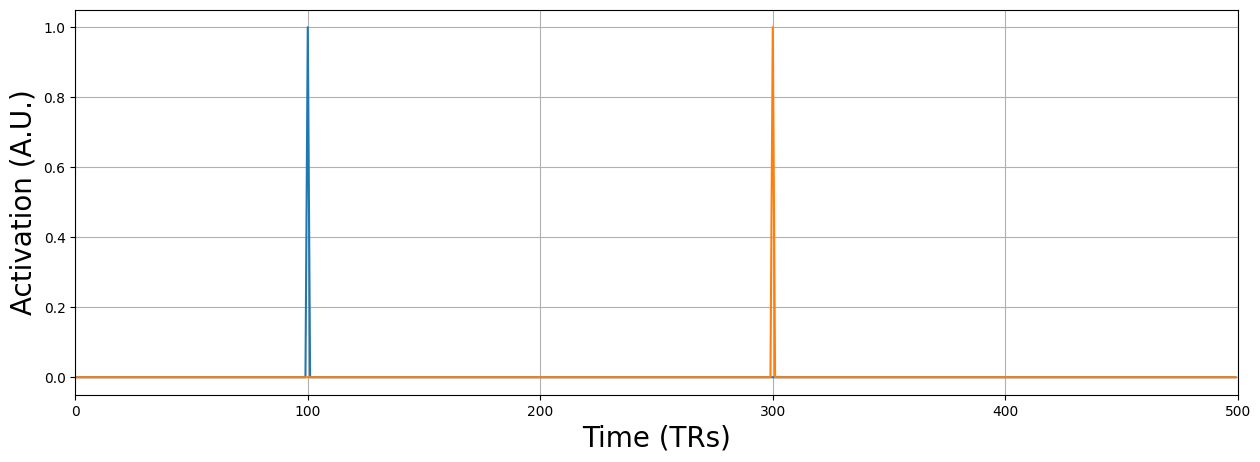

In [69]:
spike_pred = np.zeros((pred.size, n_spike))
t_spikes = np.where(identified_spikes)[0]
for i, t in enumerate(t_spikes):
    print("Creating spike predictor for t = %i" % t)
    spike_pred[t, i] = 1

plt.figure(figsize=(15, 5))
plt.plot(spike_pred)
plt.xlabel("Time (TRs)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.grid()
plt.xlim(0, pred.size)
plt.show()

<div class='alert alert-info'>
    <b>ToThink5</b>:
    
Why do you think we do not convolve the spike regressors with an HRF (or basis set)? Write your answer in the text-cell below (solution found at the end of the notebook).
</div>

Write your answer to the ToThink5 question here. Because spikes are not "activity" related to neural activity! As such, we do not expect a BOLD-response and are thus not incorporating our "hypothesis" of a HRF-shaped response in our model.


<b>Inplementing nuisance regressors in model estimation</b>: Now, we will calculate the <em>t</em>-value of the stimulus-predictor-against-baseline contrast in a model with both the stimulus predictor (<tt>pred</tt>) and the spike predictors (<tt>spike_pred</tt>). Also, we'll stack an intercept and store the <em>t</em>-value in the variable <tt>tval_spike_model</tt>. We will use <tt>spike_sig</tt> (defined below) as our target, i.e., $y$.
</div>

In [111]:

# We will calculate the effect for a single voxel:
spike_sig = all_sig[5, 5, 5, :]

# Estimate the model with only an intercept + stim predictor
X_s = np.hstack((np.ones((pred.size, 1)), pred))
b_s = inv(X_s.T @ X_s) @ X_s.T @ spike_sig
sigmahat_s = np.sum((spike_sig - X_s @ b_s) ** 2) / (X_s.shape[0] - X_s.shape[1])

#Let's find the t-value for the effect of interest using a contrast vector
c = np.array([0, 1])
desvar_s = c @ inv(X_s.T @ X_s) @ c.T
tval_nospike_model = c @ b_s / np.sqrt(sigmahat_s * desvar_s)

print(tval_nospike_model)

# Estimate the model with an intercept + stim predictor + spike predictor
X_s = np.hstack((np.ones((pred.size, 1)), pred, spike_pred))
b_s = inv(X_s.T @ X_s) @ X_s.T @ spike_sig
sigmahat_s = np.sum((spike_sig - X_s @ b_s) ** 2) / (X_s.shape[0] - X_s.shape[1])

#Let's find the t-value for the effect of interest using a contrast vector
c = np.array([0, 1, 0 ,0])
desvar_s = c @ inv(X_s.T @ X_s) @ c.T
tval_spike_model = c @ b_s / np.sqrt(sigmahat_s * desvar_s)

print(tval_spike_model)


6.934669118995247
6.9281763122003


<div class='alert alert-info'>
    <b>ToThink6</b>: An eager researcher might think that adding more and more (nuisance) predictors will always improve the amount of variance explained and thus will improve his/her chances of finding significant effects (i.e., $t$-values). Argue why this is not the case.
</div>

 Write your answer to the ToThink6 question here. The nuicance effect (e.g. a spike) may not be present in the voxel where the effect is. Additionally, the t-value depends on the number of degrees of freedom. The degrees of freedom ($N-P$) will decrease as a function of the number of predictors, which will increase the variance term of the t-value formula (up to the point where the degrees of freedom are 0 and the variance term is infinite).

<div class='alert alert-success'>
    <b>SOLUTIONS</b>

</div>

<div class='alert alert-info'>
<b>Solution to ToThink1</b>:
</div>

1. Slowly decreasing homogeneity of the magnetic field (e.g. due to subject movement)
2. Increasing thermal noise (i.e., the scanner warms up)

Note: just "subject movement" or respiration/cardiac signal is NOT correct.

<div class='alert alert-info'>
<b>Solution to ToThink2</b>:
</div>

The observed signal frequencies reflect our expected/simulated response to the stimuli! We simulated a stimulus every 40 seconds (20 TRs), which represents a frequency of 0.025 (i.e., 1 / 40)!

<div class='alert alert-info'>
<b>Solution to ToThink3</b>:
   
</div>

The intercept! This predictor makes sure that any constant variance ('offset') is modeled and thus cannot occur in the residuals.

<div class='alert alert-info'> 
<b>Solution to ToThink4</b>:
</div>

One reason could be that the noise becomes larger (the signal becomes weaker) due to increasing inhomogeneities of the magnetic field caused by, for example, subject movement. Another cause could be that subjects stop paying attention or do other things that might increase the noise over time. Note: things that cause *drift* do not necessarily lead to unequal variance across time!

<div class='alert alert-info'>
    <b>Solution to ToThink5</b>:
    
Why do you think we do not convolve the spike regressors with an HRF (or basis set)? Write your answer in the text-cell below.
</div>

Because spikes are not "activity" related to neural activity! As such, we do not expect a BOLD-response and are thus not incorporating our "hypothesis" of a HRF-shaped response in our model.

<div class='alert alert-info'>
    <b>Solution to ToThink6</b>:
</div>

The nuicance effect (e.g. a spike) may not be present in the voxel where the effect is. Additionally, the t-value depends on the number of degrees of freedom. The degrees of freedom ($N-P$) will decrease as a function of the number of predictors, which will increase the variance term of the t-value formula (up to the point where the degrees of freedom are 0 and the variance term is infinite).